<h1 style='color:orange; font-weight:bold; text-align:center'>Sentiment Prediction with TF-IDF Representation: A Conventional Machine Learning Approach</h1>

In [1]:
# DATA EXPLORATION
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import numpy as np
from sklearn.decomposition import PCA

# MODELING
import time
import nltk
from nltk.text import ConcordanceIndex
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, precision_score
from sklearn.metrics import  recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# ML EVALUATION & EXPLAINABLE AI
# from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import learning_curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
import eli5
from lime.lime_text import LimeTextExplainer
from sklearn.inspection import permutation_importance
import joblib

## **1 Experiment Setup**
In this notebook, we carry out an experiment involving conventional machine learning algorithms. Before moving on to explaining our experiment setup, we will briefly recap the key findings from the [exploratory data analysis](https://github.com/LingAdeu/sentiment-model-experiment/blob/main/notebook/01_analysis.ipynb) section because these justify some of decisions in our experiment setup. Previously, our exploration suggests the proportion between negative and positive sentiments are generally even. For this reason, the experiment setup here does not need to incorporate any resampling techniques. Text cleaning process has handled the majority of issues in review contents such as stop words, numbers, URLs, and contractions. Due to the uniqueness of words in negative and positive reviews, we will consider an implementation of Term Frequency-Inverse Document Frequency (TF-IDF; [Jones, 1972](https://doi.org/10.1108/eb026526)) to represent the reviews.

<center>
<img src="../img/ExperimentDesign.png" alt="Centered Image" style="max-width: 50%; height: auto;">
</center>

**Algorithms**: We include and comparee four types of conventional machine learning algorithms, namely tree-based (e.g., Decision Tree, Random Foreest, Gradient Boosting, Adaboost, XGBoost, and CatBoost), linear (e.g., Logistic Regression, Support Vector Machine), distance-based (e.g., K-Nearest Neighbor), and Bayesian (e.g., Multinomial Naive Bayes and Complement Naive Bayes). Even though this list of algorithms are not exhaustive, we attempt to include as many as possible while maintaining computational efficiency. To prevent overfitting, stratified $k$-fold cross-validation is implemented to prevent overfitting by ensuring each fold ($k$) of the dataset has a similar distribution of classes.

**Text representation**: TF-IDF consists of two main components, namely term frequency (TF) and inverse document frequency (IDF). TF denotes the frequency of a term in every document, and therefore, highlights the local distribution of the term in a document. Additionally, IDF tells the importance of a term in the entire collection of reviews. IDF helps to reduce the weight of a term appearing frequently across many documents. Hence, IDF highlights the uniqueness of a term in a specific document.

$$
\begin{align}
\text{TF-IDF}(t,d) &= \text{TF}(t,d) \times \text{IDF}(t)\\
\text{TF}(t,d) &=\text{frequency of term }t \text{ in document } d\\
\text{IDF}(t) &= \log \frac{\text{total documents}}{\text{number of documents with term }t}
\end{align}$$

**Evaluation metrics**: Whilw our primary metric in this project will be F1 score which provides a single score reflecing a model's performance on both types of errors, we also implement several evaluation metrics in our projects to provide more comprehensive insight into the models performance. First, F1 score is the harmonic mean of both precision and recall. This metric is ideal when we want to balance beetween precision and recall. Second, precision evaluates the correctness of correct predictions of positive class (positive sentiment). This is a common metric to use when the cost of false positive (actual negative but predicted positive) is high, e.g., in spam detection. Last, recall tells the ability of a model to retrieve all relevant instances (true positives)

$$
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}\\
\text{Precision} =\frac{TP}{TP+FP}\\
\text{Recall} = \frac{TP}{TP+FN}
$$

## **2 Model Experiment**
### **2.1 Data Preparation**

In [2]:
# load dataset
df = pd.read_csv('../data/cleaned_data.csv', usecols=['CleanReview', 'Sentiment'])

#### **2.1.1 Data Overview and Problem Handling**

In [3]:
# function to inspect dataframe
def inspect_dataframe(df):
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean()*100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'UniqueValues': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

In [4]:
# inspect dataframe
print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols')
print(f"- {len(df.select_dtypes(include='number').columns)} are numeric cols")
print(f"- {len(df.select_dtypes(include='O').columns)} are object cols")
inspect_dataframe(df)

The dataframe contains 5393 rows and 2 cols
- 0 are numeric cols
- 2 are object cols


ColumnName  Nrow DataType  NAPct  DuplicatePct  UniqueValues  \
0    Sentiment  5393   object    0.0          2.78             2   
1  CleanReview  5393   object    0.0          2.78          5243   

                                              Sample  
0                               [Positive, Negative]  
1  [alhamdulillah berfungsi dengan baik packaging...

**Comment**
- As the main variables used in the predictive modeling are clean reviews (feature) and sentiment (target), only these variables are included during data import. The dataset has been cleaned previously in the data exploratory analysis phase so cleaning process will not be exhausted in the data preprocessing step for the machine learning model experiment. 
- We will perform feature extraction from clean reviews and vectorize the new features using term frequency-inverse document frequency (TF-IDF).
- As shown above, the dataset when being subset contains around 3% of duplicates (see duplicated instances below). These duplicates will be removed to prevent potential overfitting on the model performance.
- Becuase the sentiment labels are still in the form of categorical data, they will be encoded into `0` and `1` for negative and positive, respectively. The categories must be converted since machine learning algorithms we use only take numerical inputs.

In [5]:
# check duplcates
df[df.duplicated(keep=False)].sort_values(by='CleanReview').head()

Sentiment                                        CleanReview
1972  Negative                ancur bubuk remuk tak berbentukllkl
1902  Negative                ancur bubuk remuk tak berbentukllkl
1960  Negative  ancur dah pelayanannya gausah kesini dah kalau...
1888  Negative  ancur dah pelayanannya gausah kesini dah kalau...
1934  Positive                                              bagus

In [6]:
# remove duplicates
df.drop_duplicates(keep='first', inplace=True)

**Comment**: While previously we did not find any more duplicates during the EDA, subsetting data leads to duplicating values twice. This might indicate that other variables serve as the discriminatory factors for each instance in the dataset. And to handle the duplicates, the first instances are be kept meanwhile the rest duplicated values are dropped.

#### **2.1.2 Train-Test Split and Vectorization**

In [7]:
# prepare features and labels
X = df['CleanReview']
y = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# vectorize texts 
vectorizer = TfidfVectorizer()  
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [9]:
print(f'The X_train consists of {X_train_tfidf.shape[0]} rows and {X_train_tfidf.shape[1]} columns')
print(f'The y_train consists of {y_train.shape[0]} rows')
print(f'X_test consists of {X_test_tfidf.shape[0]} rows and {X_test_tfidf.shape[1]} columns')
print(f'The y_test consists of {y_test.shape[0]} rows')

The X_train consists of 4194 rows and 7129 columns
The y_train consists of 4194 rows
X_test consists of 1049 rows and 7129 columns
The y_test consists of 1049 rows


In [10]:
# view vectorization output
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.iloc[:5, :20]

aa  aamiin  aamiinn   ab  abaikan  abal  abang  abangnya  abbot  abbott  \
0  0.0     0.0      0.0  0.0      0.0   0.0    0.0       0.0    0.0     0.0   
1  0.0     0.0      0.0  0.0      0.0   0.0    0.0       0.0    0.0     0.0   
2  0.0     0.0      0.0  0.0      0.0   0.0    0.0       0.0    0.0     0.0   
3  0.0     0.0      0.0  0.0      0.0   0.0    0.0       0.0    0.0     0.0   
4  0.0     0.0      0.0  0.0      0.0   0.0    0.0       0.0    0.0     0.0   

   abc  abis  abisin  abon  abu  abux   ac  acak  acakan  acara  
0  0.0   0.0     0.0   0.0  0.0   0.0  0.0   0.0     0.0    0.0  
1  0.0   0.0     0.0   0.0  0.0   0.0  0.0   0.0     0.0    0.0  
2  0.0   0.0     0.0   0.0  0.0   0.0  0.0   0.0     0.0    0.0  
3  0.0   0.0     0.0   0.0  0.0   0.0  0.0   0.0     0.0    0.0  
4  0.0   0.0     0.0   0.0  0.0   0.0  0.0   0.0     0.0    0.0

**Comment**
- Splitting dataset into train and test set allows us to evaluate how well the model generalize its learning outcome from training set to the unseen data (test set). This data split also prevent data leakage. Data leakage happens when data used for training accidentally used during testing. Here we set 80% for data training and 20% for data testing.
- Furthermore, because the feature (`X`) is still in the original format, we perform feature extraction and vectorize those features with TF-IDF. The examples of the vectors along with the features can be seen above.
- Evaluating the vectorization output, it appears that the data cleaning process does not resolve all problems, especially for reduplication. In morphology, reduplication occurs when a word or a part of it is being reduplicated. This morphological phenomenon is common in Indonesian where the reduplications serves as intensification (e.g., *Ikannya **besar-besar** ya*), diminiutivization (e.g., *Dia tinggal di **rumah-rumah** kecil di desa*), iterative (e.g., *Kami **jalan-jalan** ke Solo kemarin*), distributive (e.g., *Anak-anak **main-main** di halaman rumah*).
- The reduplications are split up into different words because all punctuation marks, especially hyphens, were removed and the reduplications were split up. Semantically, this data cleaning leads to meaning loss. But we will see later whether this is a major issue in the model.
- Other issues include treating words with inclusion of enclitic *-nya* and non-standard forms *abux* $\rightarrow$ *abu* + *x* (*nya*). These issues are unavoidable since currently, no data preprocessing technique can handle all of these problems at once.
- Fortunately, nonstandard enclitic *-x* to represent *-nya*, is a hapax legomenon, a phenomeonon in which a linguistic item only occurs once in a corpus. Hence, it should not be concerns. 

In [11]:
# join reviews with score 1 into one text
corpus = ' '.join(df['CleanReview'].tolist())

# build concordance index
conc_index = ConcordanceIndex(nltk.word_tokenize(corpus))

# display the KWIC
conc_index.print_concordance('abux', width=100, lines=10)

Displaying 1 of 1 matches:
 warna sepatu di deskripsi aga crem yang dateng abux gelap baru di pake sekali udah robek sol nya se


In [12]:
# apply PCA to reduce TF-IDF dimensions to 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())

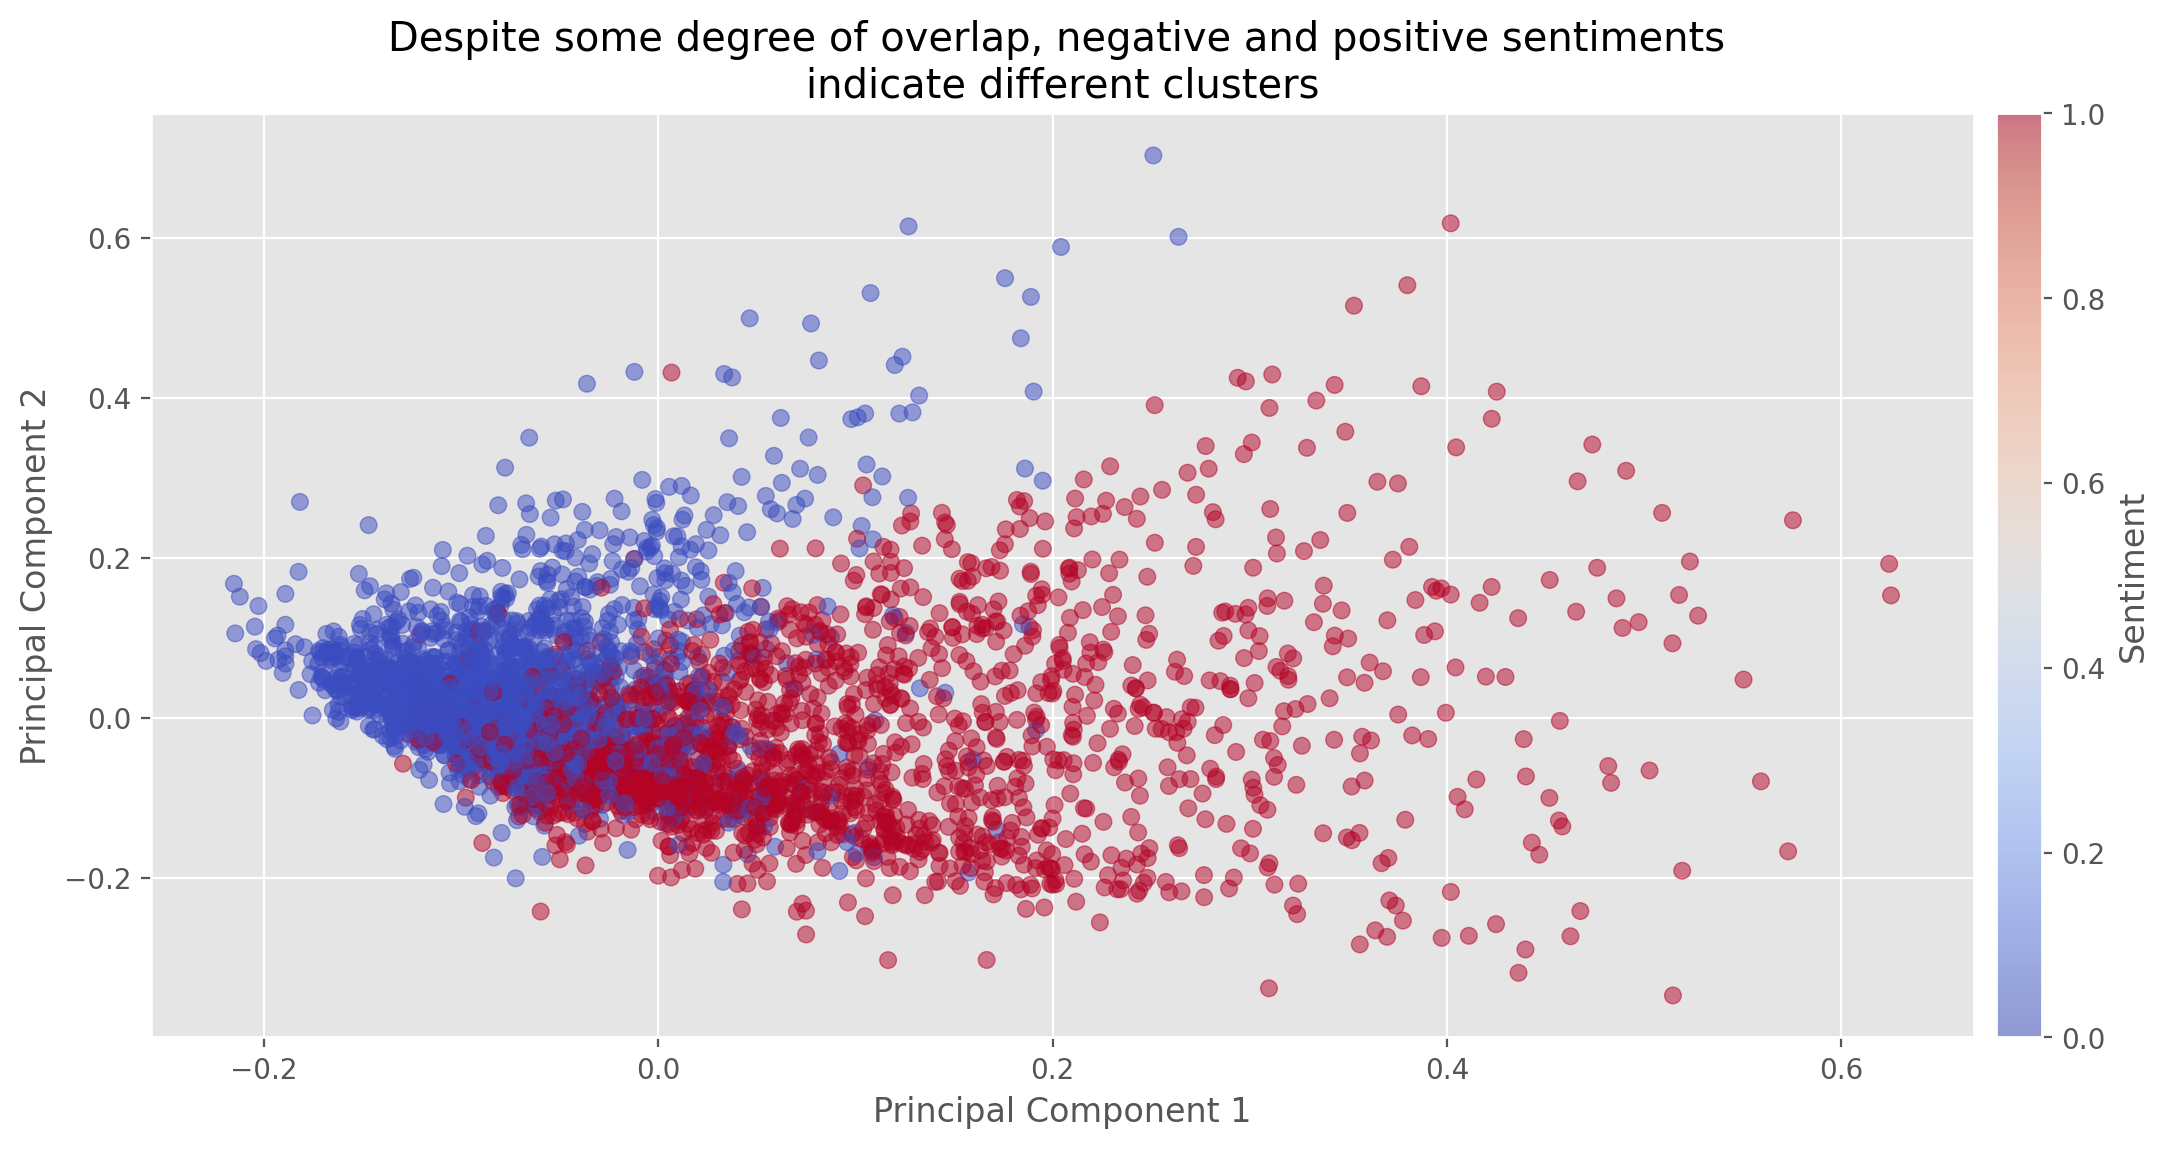

In [13]:
# plot PCA result
plt.figure(figsize=(14, 6), dpi=200)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.5)
plt.title('Despite some degree of overlap, negative and positive sentiments \nindicate different clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# adjust the colorbar
cbar = plt.colorbar(scatter, label='Sentiment', pad=0.01)  # adjust shrink and pad
plt.show()

**Comment**
- The scatter plot suggests the data points, representing word featurees, have two distinct clusters. This means that word features potentialy can be separated into two primary groups based on their sentiments. 
- Some degree of overlap between negative and positive sentiments is present, suggesting the sentiments are not entirely clear cut. As previously demonstrated, negative and positive sentiments share common words such as *banget* (very), *barang* (product), and *pengiriman* (delivery).

#### **2.1.3 Algorithm and Scoring Setup**

In [14]:
# specify models
classifiers = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', random_state=42)),   # Linear
    ('K-Nearest Neighbors', KNeighborsClassifier()),                                    # Distance-based
    ('Support Vector Machine', SVC(probability=True)),                                  # Linear with kernel (default RBF)
    ('Naive Bayes', MultinomialNB()),                                                   # Naive Bayes
    ('Complement Naive Bayes', ComplementNB()),                                         # Naive Bayes
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),                         # Tree-based
    ('Random Forest', RandomForestClassifier(random_state=42)),                         # Tree-based
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),                 # Tree-based
    ('AdaBoost', AdaBoostClassifier(random_state=42)),                                  # Tree-based
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                              random_state=42)),                                        # Tree-based
]

# specify scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='micro', zero_division=0),
    'recall': make_scorer(recall_score, average='micro', zero_division=0),
    'f1': make_scorer(f1_score, average='micro', zero_division=0),
}

# specify stratified k-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**Comment**
- Above we set up algorithms we will use for comparing models. The list has included different types of algorithms such as linear, distance-based, Bayesian, and tree-based. Our purpose of including different types of algorithms is to find out which types excels the classification task on our dataset. 
- Furthermore, the scoring metrics to evaluate the machine learning model performance have been setup. In addition to F1 as our primary evaluation metric, we also incorporate precision, recall, and accuracy. Precision and recall are included because the components of F1 are precision and recall.

### **2.2 Model Comparison**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [15]:
# evaluate each model
results = []
for name, model in classifiers:
    scores = {}
    start_time = time.time()
    for metric_name, scorer in scoring.items():
        cv_results = cross_validate(model, X_train_tfidf, y_train, cv=skf,
                                    scoring=scorer, n_jobs=-1)
        scores[f"{metric_name}"] = np.mean(cv_results['test_score'])
        scores[f"{metric_name}_sd"] = np.std(cv_results['test_score'])
    end_time = time.time()
    training_time = end_time - start_time
    scores['training_time'] = training_time
    results.append((name, scores))

In [16]:
# show results
results_df = pd.DataFrame(results, columns=['Model', 'Scores'])
scores_df = results_df['Scores'].apply(pd.Series)
results_df = pd.concat([results_df[['Model']], scores_df], axis=1).round(3)
results_df = results_df.set_index('Model')
(results_df.sort_values(by='f1', ascending=False)
 .style.highlight_max(subset=['f1', 'accuracy', 'precision', 'recall'], color='orange'))

**Comment**
- The model comparison suggests that Support Vector Machine (SVM) model outperforms other models based on F1 score (0.948 $\pm$ 0.005). In addition to F1 score, SVM remains top prforming model basd on the accuracy (0.948 $\pm$ 0.005), precision (0.948	$\pm$ 0.005), and recall (0.948 $\pm$ 0.005). The minimal standard deviations across 5 validation folds show the stability of the SVM model performance. These highest scores, moreover, indicates the effectiveness of SVM model in learning the patterns of sentiment in the reviews.
- SVM usually excels in high-dimensional data. It can find optimal hyprplane maximizing margin between classes to separate sentiments. For high-dimensional data, SVM is generally robust to overfitting. 

In [17]:
# get model names
best_model_name = results_df['f1'].idxmax()
worst_model_name = results_df['f1'].idxmin()
best_f1_score = results_df.loc[best_model_name, 'f1']
worst_f1_score = results_df.loc[worst_model_name, 'f1']
best_f1_std = results_df.loc[best_model_name, 'f1_sd']
worst_f1_std = results_df.loc[worst_model_name, 'f1_sd']

# print best & worst model
print(f'Best model: {best_model_name}, F1 score: {best_f1_score:.3f}, SD: {best_f1_std:.3f}')
print(f'Worst model: {worst_model_name}, F1 score: {worst_f1_score:.3f}, SD: {worst_f1_std:.3f}')

Best model: Support Vector Machine, F1 score: 0.948, SD: 0.005
Worst model: Decision Tree, F1 score: 0.863, SD: 0.007


### **2.3 Model Development**
Based on SVM's rank based on F1 scores on the model comparison, the model which will be developed and tuned is Support Vector Machine. The model comparison shows that SVM model outperforming other models with F1 scoree of 0.948 $\pm$ 0.005. Given this excellent result, this section is concerned with building SVM model and test the model on the unseen dataset before performing hyperparameter tuning. The output from this section will be compared to the output from the hyperparameter tuning to investigate to what extent the hyperparameter tuning can improve the model's performance and check whether the current setup has been optimized.

In [54]:
# retrieve best model name
best_model_ori = dict(classifiers)[best_model_name]

# create pipeline with best model
best_pipeline = Pipeline(steps=[
    ('vectorizer', vectorizer),
    ('classifier', best_model_ori)
])

# fit model on training data
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', SVC(probability=True))])

In [55]:
# make predictions on the test data (use X_test, not X_test_tfidf)
predictions = best_pipeline.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='micro', zero_division=0)
recall = recall_score(y_test, predictions, average='micro', zero_division=0)
f1 = f1_score(y_test, predictions, average='micro', zero_division=0)

# create df to store the metrics
test_ori = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
})

# display results
display(test_ori)

Metric     Score
0   Accuracy  0.951382
1  Precision  0.951382
2     Recall  0.951382
3   F1 Score  0.951382

In [20]:
# print metrics
print('Classification report:')
print(classification_report(y_test, predictions, target_names=['Negative', 'Positive']))

Classification report:
              precision    recall  f1-score   support

    Negative       0.93      0.98      0.96       557
    Positive       0.98      0.92      0.95       492

    accuracy                           0.95      1049
   macro avg       0.95      0.95      0.95      1049
weighted avg       0.95      0.95      0.95      1049



**Comment**: The classification report suggests that the SVM model has excellent performance in the testing data. The peformance is equally good at both negative and positive sentiment with F1 scores of 0.96 and 0.95.

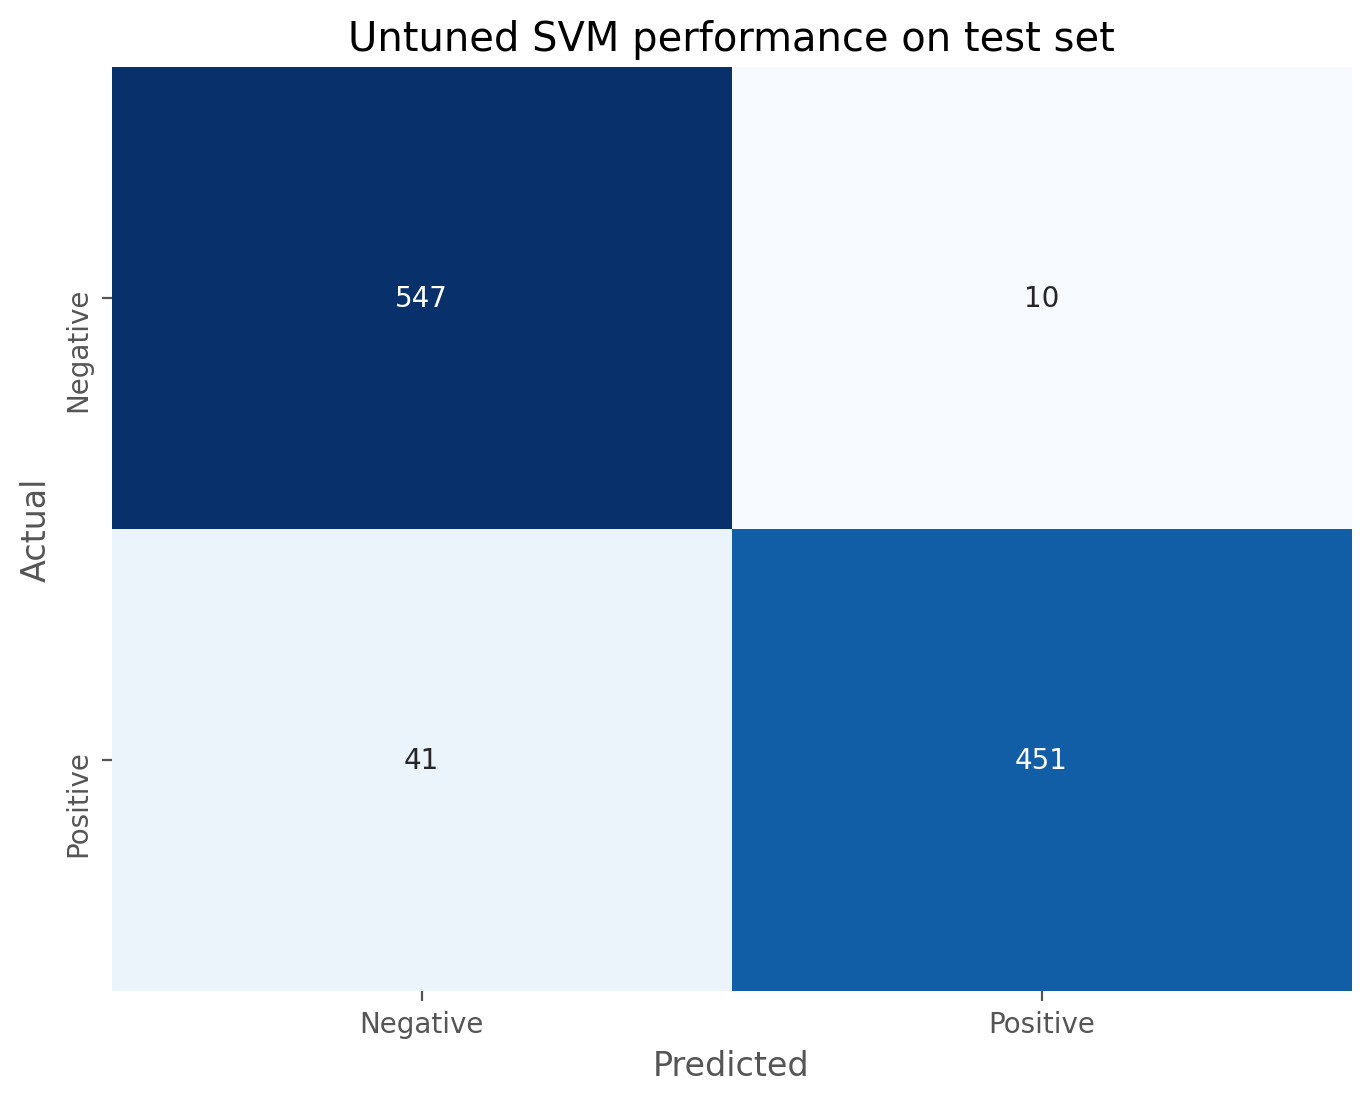

In [21]:
# get confusion matrix
y_pred_untuned = best_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred_untuned)

# display confusion matrix
plt.figure(figsize=(8, 6), dpi=200)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Untuned SVM performance on test set')
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'])
plt.show()

**Comment**: When checking the confusion matrix, the original model (untuned) have reasonably good performance at minimizing false positives (actual: negative sentiment, predicted: positive sentiment) but it needs tuning to decrease the false negatives (actual: positive sentiment, predicted: negative sentiment). 

### **2.4 Model Tuning**
In this section, we perform hyperparameter tuning on Support Vector Machine model which previously achieved an excellent score of F1 but this model remains having some issues with minimizing false negatives. The model tuning here will involve three different hyperaprameters, namely `C` for controlling regularization, `kernel` for experimenting with different SVM kernels, and `gamma` for kernel coefficient. The model tuning will be carried out by using grid search, exhaustively searching best hyperparameter for the SVM model based on F1 score. It searches all best possible combinations of hyperparameters. The illustration of how it works can be seen on the figure below.

<center>
<img src="../img/GridSearch.png" alt="Centered Image" style="max-width: 40%; height: auto;">
</center>

In [22]:
# define parameter grid
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],         # regularization parameter
    'classifier__kernel': ['linear', 'rbf'],    # type of kernel
    'classifier__gamma': ['scale', 'auto']      # kernel coefficient
}

# set up GridSearchCV for model tuning
grid_search = GridSearchCV(estimator=best_pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           n_jobs=-1,
                           verbose=0)          

In [23]:
# fit GridSearchCV
grid_search.fit(X_train, y_train)

# get best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.3f}")

Best Parameters: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best Cross-Validation Score: 0.948


In [24]:
# get best model from grid search
best_model = grid_search.best_estimator_

# make predictions on test set
predictions = best_model.predict(X_test)

In [25]:
# compute performance scores
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='micro', zero_division=0)
recall = recall_score(y_test, predictions, average='micro', zero_division=0)
f1 = f1_score(y_test, predictions, average='micro', zero_division=0)

# create df to store test outputs
test_tuned = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
})

# display output
display(test_tuned)

Metric     Score
0   Accuracy  0.959962
1  Precision  0.959962
2     Recall  0.959962
3   F1 Score  0.959962

In [26]:
print('Classification report (tuned model):')
print(classification_report(y_test, predictions, target_names=['Negative', 'Positive']))

Classification report (tuned model):
              precision    recall  f1-score   support

    Negative       0.95      0.98      0.96       557
    Positive       0.98      0.94      0.96       492

    accuracy                           0.96      1049
   macro avg       0.96      0.96      0.96      1049
weighted avg       0.96      0.96      0.96      1049



In [27]:
# Predict on the test set for both models
y_pred_test_ori = best_pipeline.predict(X_test)
y_pred_test_tuned = best_model.predict(X_test)

# Compute confusion matrices
cm_ori = confusion_matrix(y_test, y_pred_test_ori)
cm_tuned = confusion_matrix(y_test, y_pred_test_tuned)

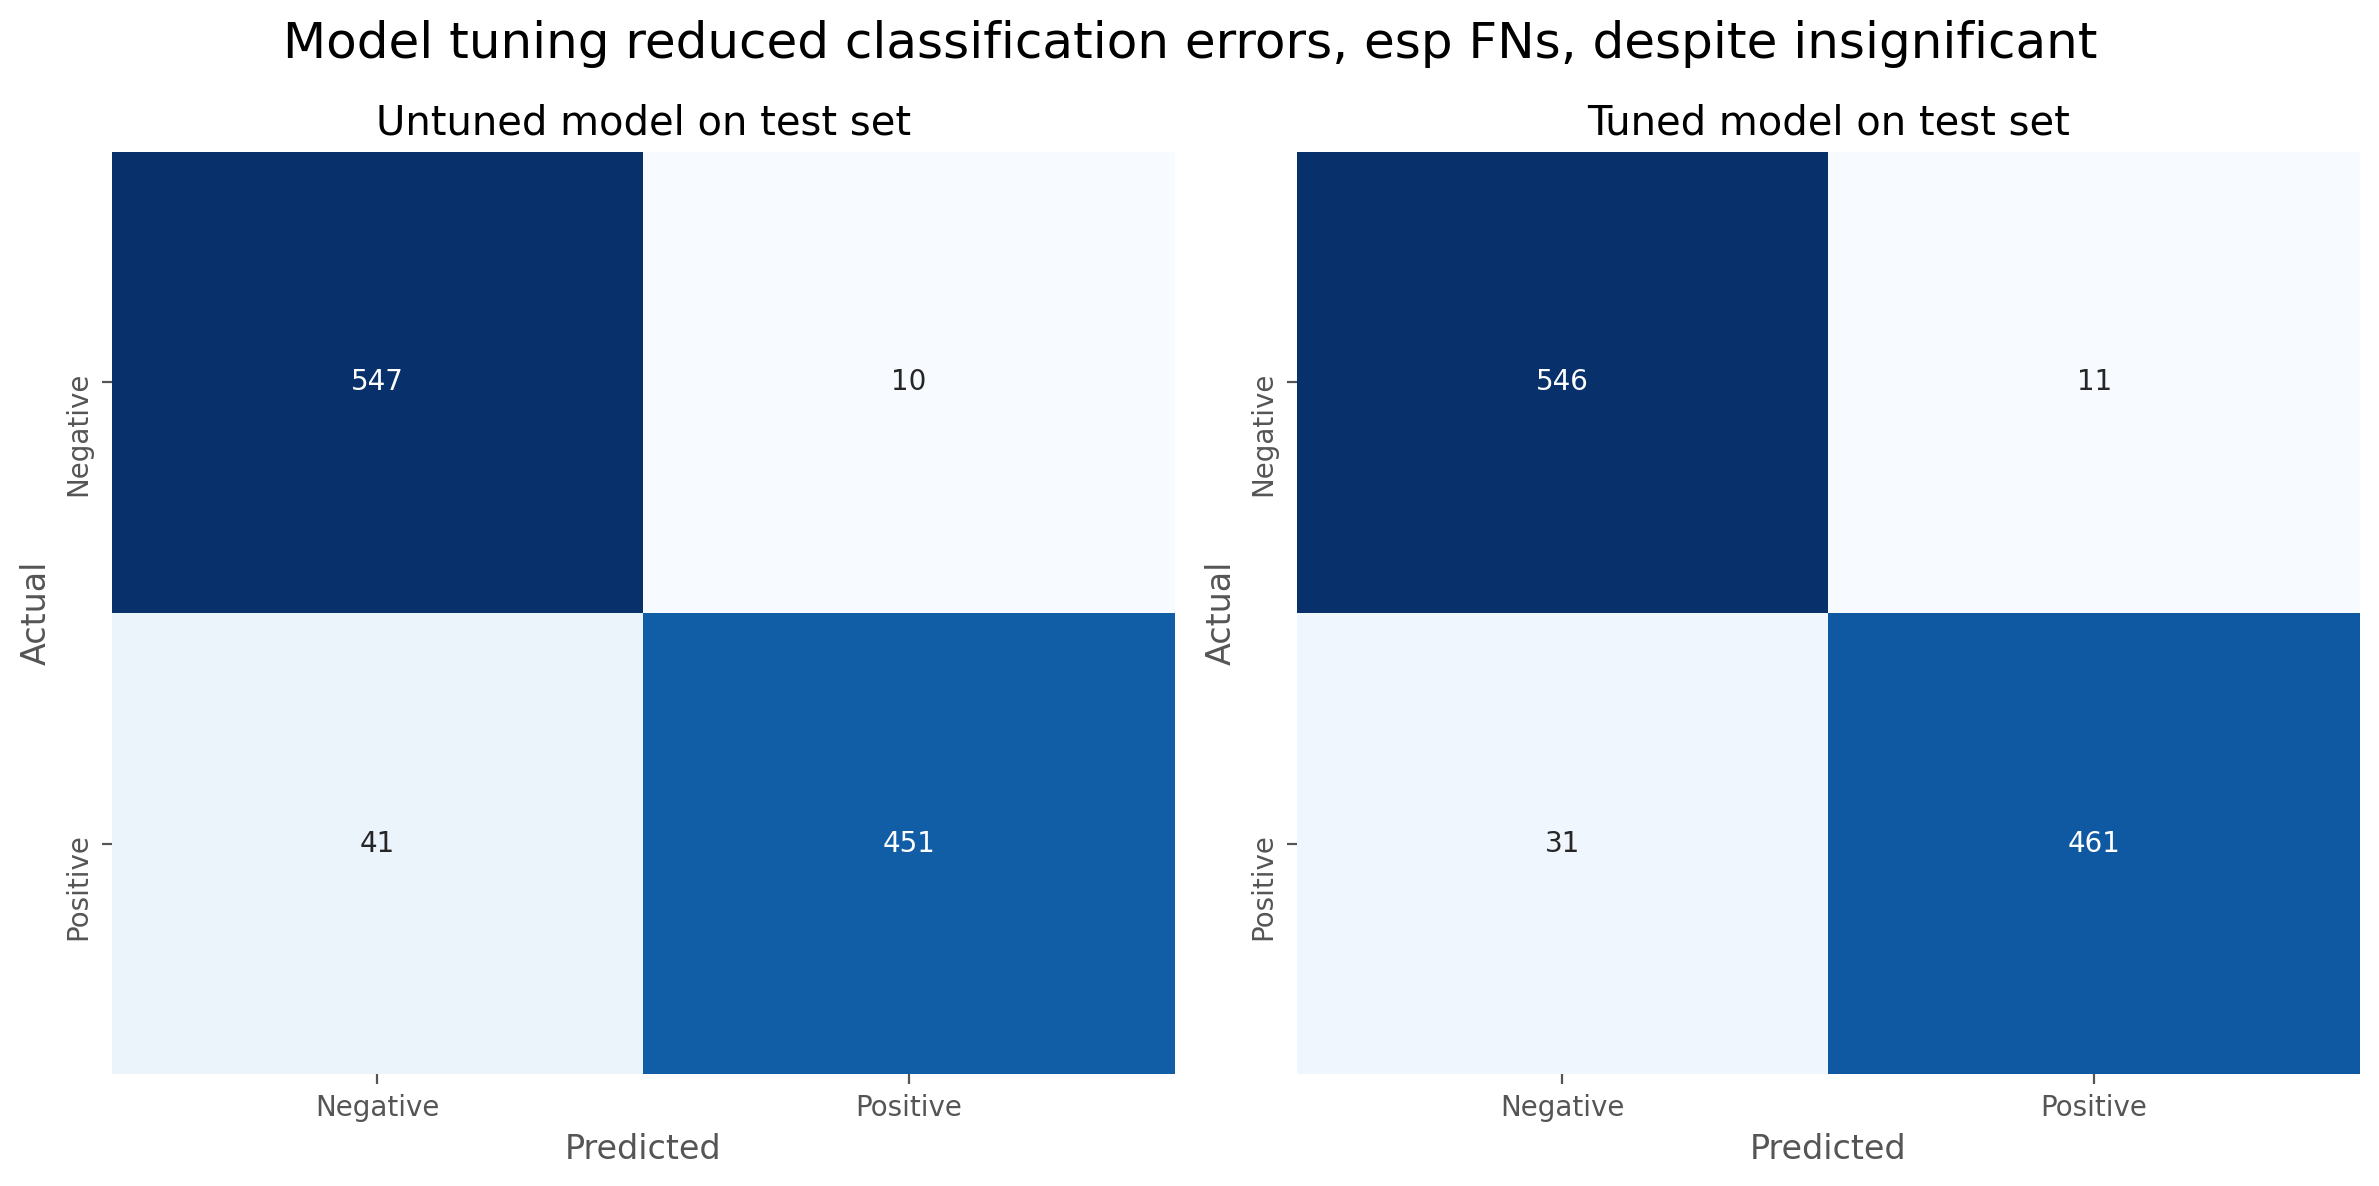

In [57]:
# create figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=200)

# plot confusion matrix for untuned model
sns.heatmap(cm_ori, annot=True, fmt='g', ax=axs[0], cmap='Blues', cbar=False)
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_title('Untuned model on test set')
axs[0].set_xticklabels(['Negative', 'Positive'])
axs[0].set_yticklabels(['Negative', 'Positive'])

# plot confusion matrix for tuned model
sns.heatmap(cm_tuned, annot=True, fmt='g', ax=axs[1], cmap='Blues', cbar=False)
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Tuned model on test set')
axs[1].set_xticklabels(['Negative', 'Positive'])
axs[1].set_yticklabels(['Negative', 'Positive'])

plt.suptitle('Model tuning reduced classification errors, esp FNs, despite insignificant', size=18)
plt.tight_layout()
plt.show()

**Comment**: The confusion matrices above summarize the performance of both untuned and tuned model when making predictions on the unseen data. Overall, the majority of data have been correctly classified to the respective sentiment labels. Moreover, the hyperparameter tuning of the SVM model shows that the number of classification errors, particularly false negatives, have reduced by 10 whereas the false positives increased by 1. These results reflect that the hyperparameter tuning tried to slighly balanced the false negatives and false positives by reducing the number of false negatives significantly. For the record, the metric of evaluation in the grid search is F1 score to justify the model's attempt to slighly balance the errors.

## **3 Model Evaluation and Explaination (XAI)**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

### **3.1 Best Model Evaluation**
#### **3.1.1 ROC-AUC Curve**
Receiver Operating Characteristic - Area Under the Curve (ROC-AUC) informs the model's discriminatory power between each class across all classification thresholds. ROC-AUC consists of two main components, i.e., true positive rate (TPR or recall) and false positive rate (FPR). They can be calculated using the formulas below. And after obtaining each score, ROC curve can be visualized.

$$\text{TPR}=\frac{TP}{TP+FN}$$
$$\text{FPR}=\frac{FP}{FP+TN}$$

In [29]:
# get pred proba for positive class (positive sentiment)
y_prob_test = best_model.predict_proba(X_test)[:, 1]

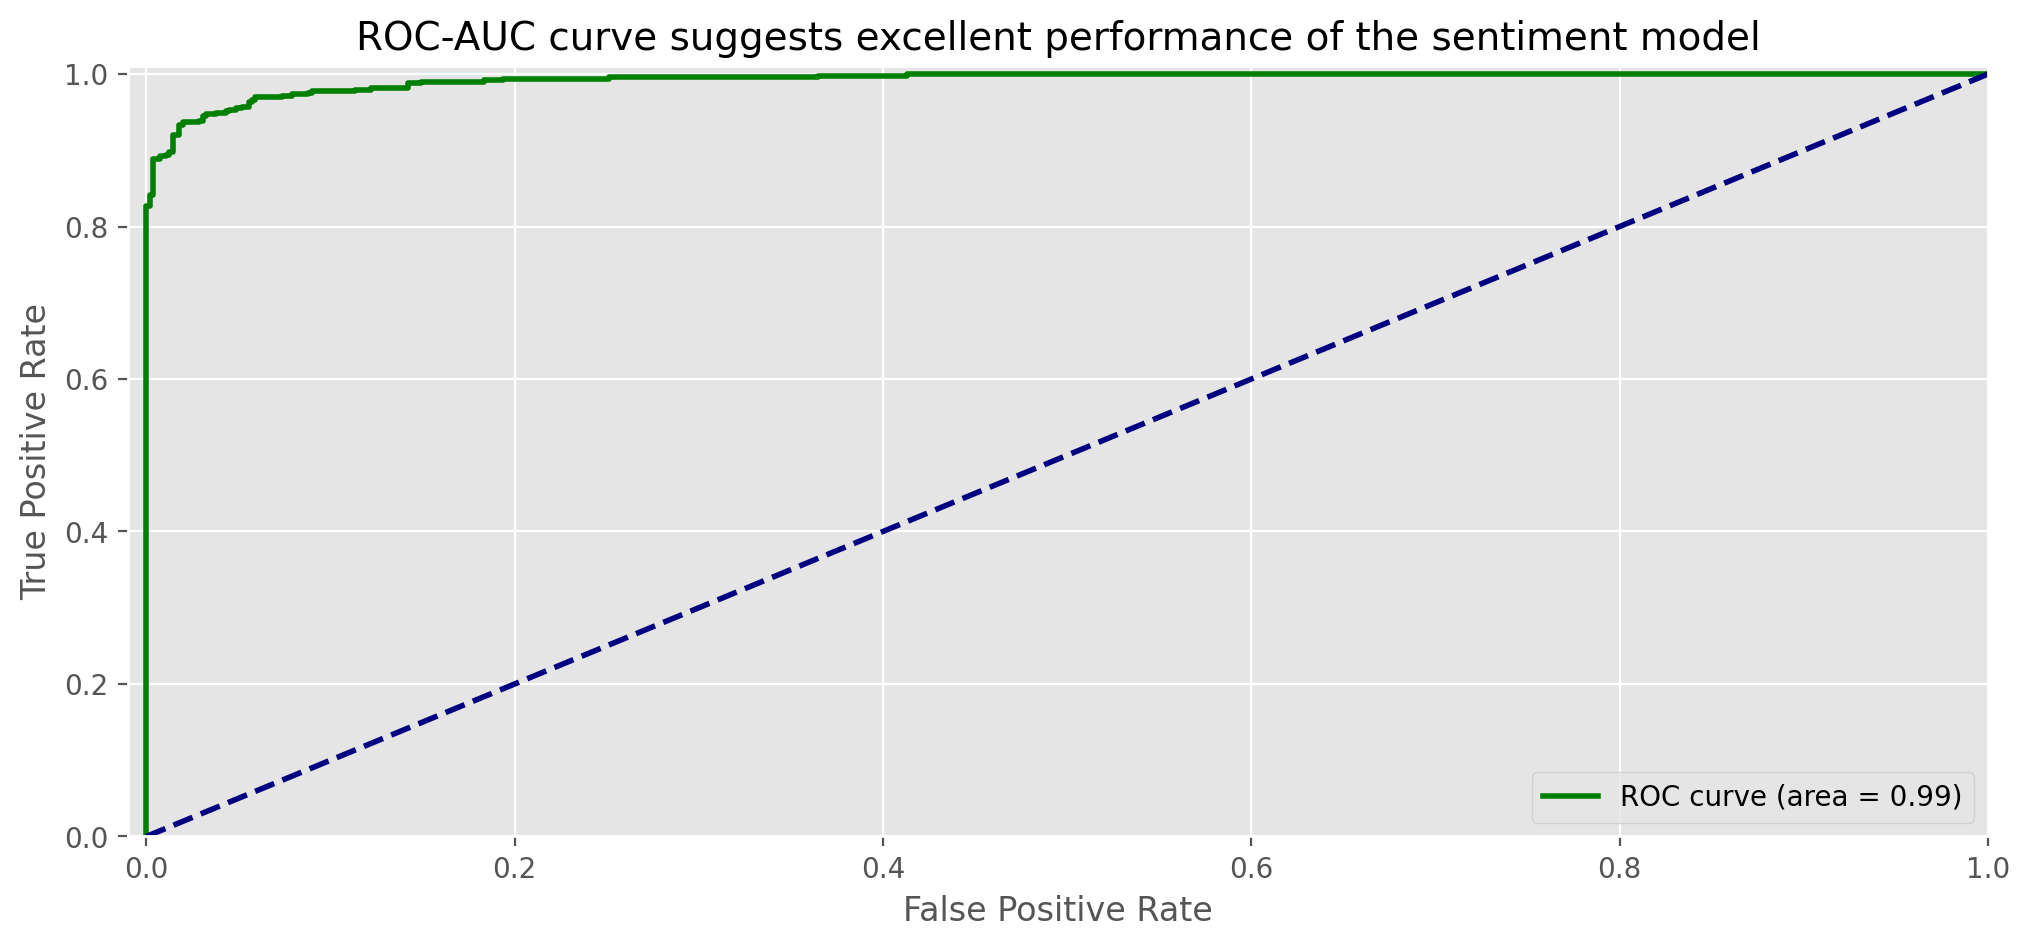

In [30]:
# plot ROC-AUC curve
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5), dpi=200)
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve suggests excellent performance of the sentiment model', fontsize=14)
plt.legend(loc="lower right")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.01)
plt.show()

**Comment**: Overall the ROC-AUC suggests that model has excellent performance. First, AUC score is very close to 1, indicating a high ability to distinguish between negative and positive classes. Second, the ROC curve is close to the top left corner of the plot, suggesting a high true psitive rate (TPR) and low false positive rate (FPR) across different thresholds.

#### **3.1.2 Precision-Recall Curve**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

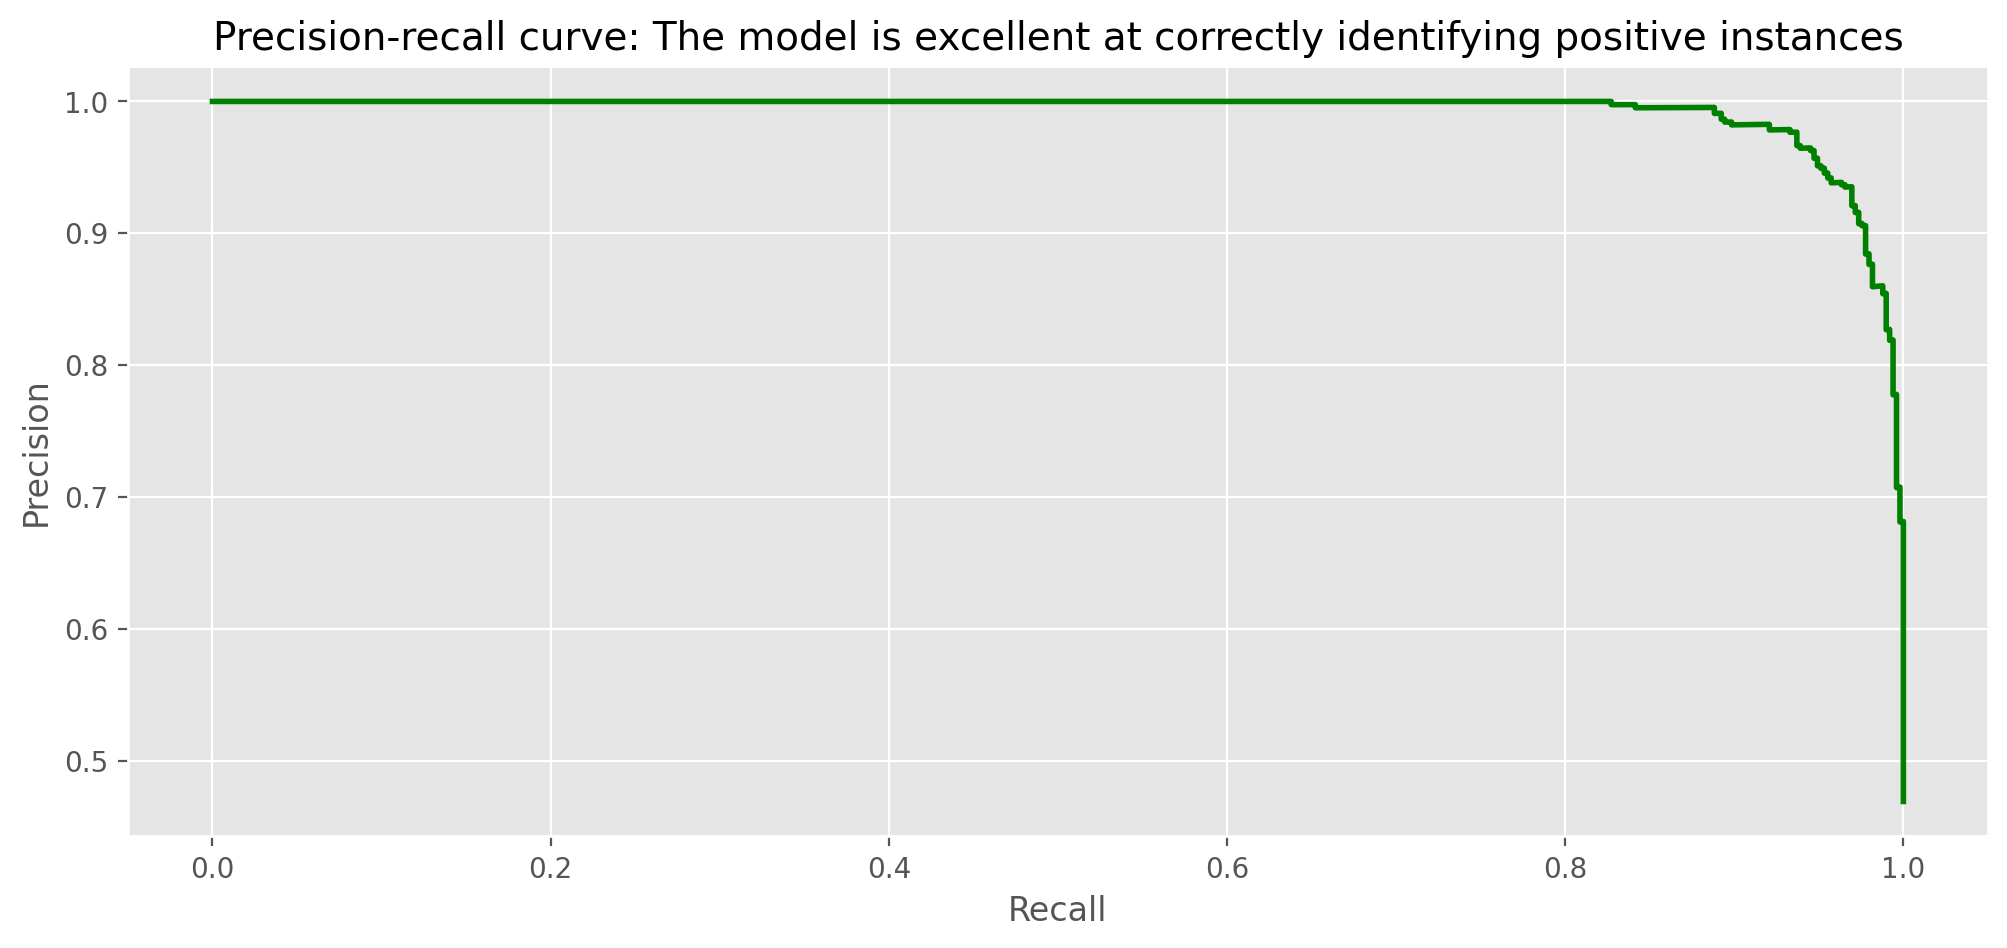

In [31]:
# plot PR curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_test)

plt.figure(figsize=(12, 5), dpi=200)
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve: The model is excellent at correctly identifying positive instances', size=14)
plt.show()

#### **3.1.3 Learning Curve**

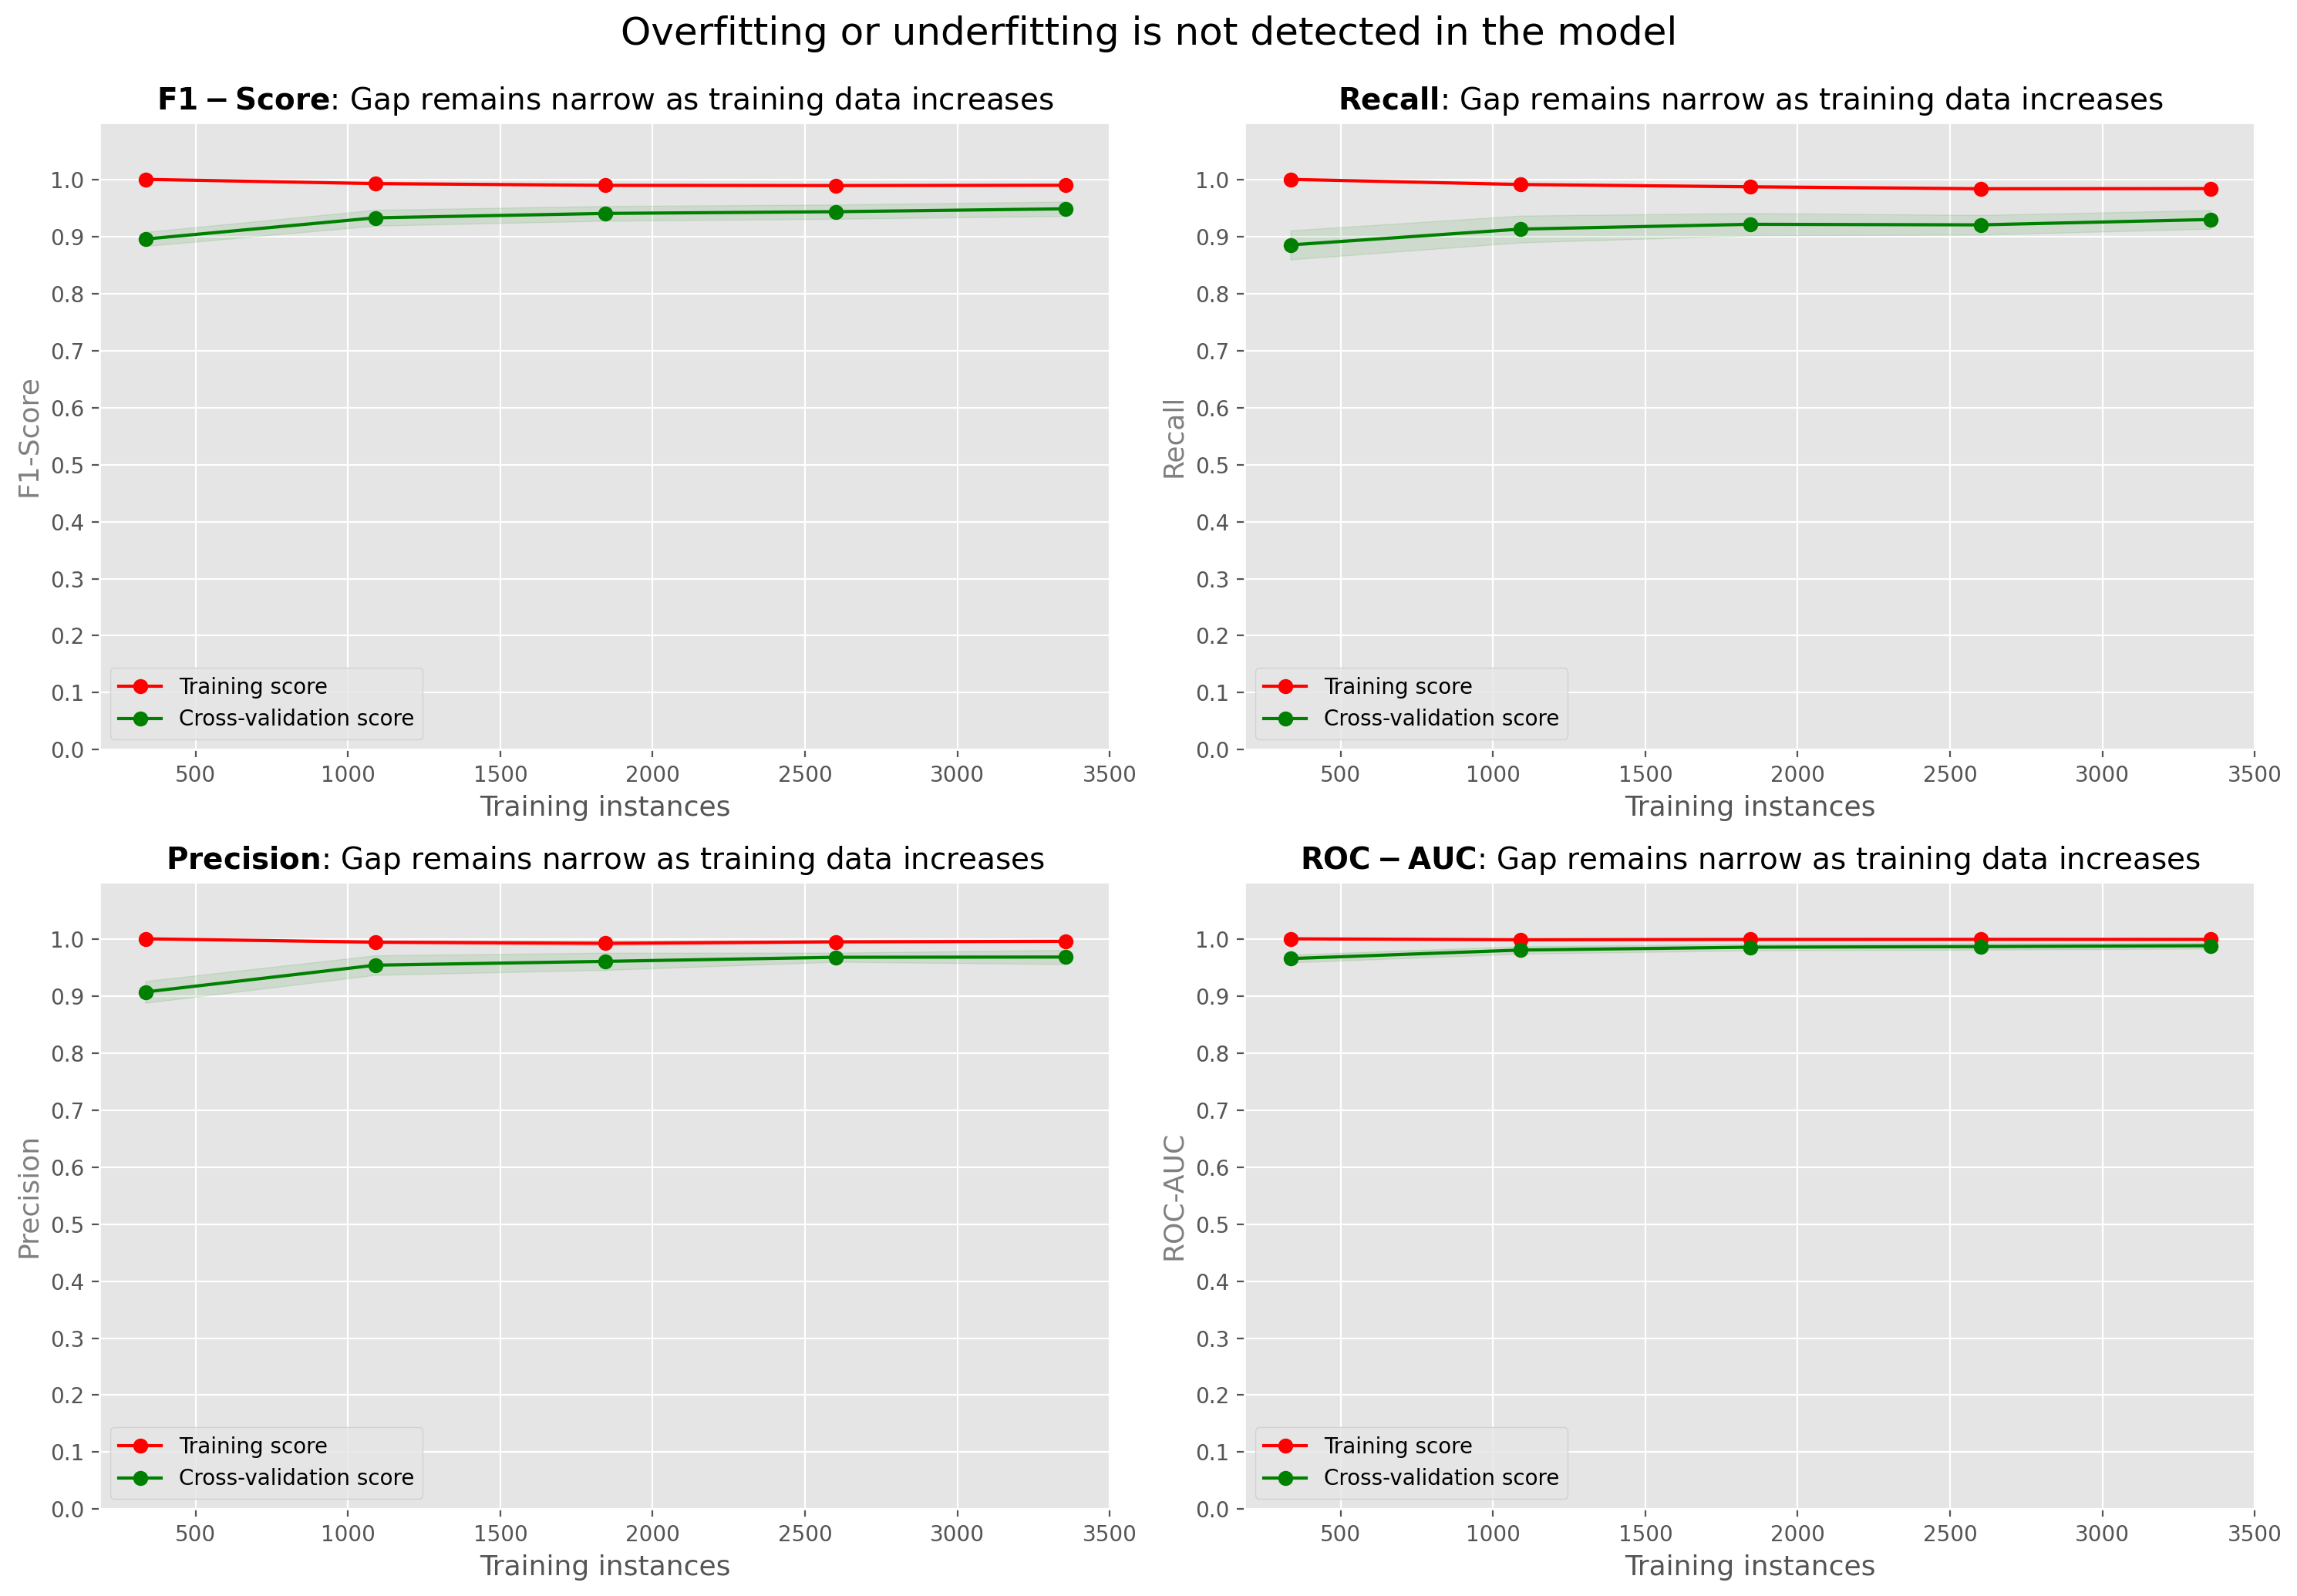

In [32]:
# define the metrics
metrics = {
    'F1-Score': 'f1',
    'Recall': 'recall',
    'Precision': 'precision',
    'ROC-AUC': 'roc_auc'
}

# init the figure and axis array
fig, axes = plt.subplots(2, 2, figsize=(15, 10), dpi=200)
axes = axes.ravel()  

# loop through each metric
for i, (metric_name, metric) in enumerate(metrics.items()):
    train_sizes, train_scores, test_scores = learning_curve(
        best_model, X_train, y_train, cv=5, scoring=metric, n_jobs=-1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[i].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    axes[i].set_xlabel('Training instances', size=13)
    axes[i].set_ylabel(metric_name, size=13, color='grey')
    axes[i].set_title(rf'$\bf{{{metric_name}}}$: Gap remains narrow as training data increases', size=14)
    axes[i].legend(loc="best")
    axes[i].set_ylim(0, 1.1)
    axes[i].set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()
plt.suptitle('Overfitting or underfitting is not detected in the model', 
             y=1.03, size=18)
plt.show()

In [33]:
# ROC-AUC (for adding details)
learning_curve_data = pd.DataFrame({
    'training_mean': train_scores_mean,
    'training_sd': train_scores_std,
    'testing_mean': test_scores_mean,
    'testing_sd': test_scores_std
}).round(3)
learning_curve_data['mean_diff'] = learning_curve_data['training_mean'] - learning_curve_data['testing_mean']
display(learning_curve_data)

training_mean  training_sd  testing_mean  testing_sd  mean_diff
0          1.000        0.000         0.965       0.007      0.035
1          0.998        0.001         0.980       0.007      0.018
2          0.999        0.000         0.985       0.006      0.014
3          0.999        0.000         0.986       0.006      0.013
4          0.999        0.000         0.988       0.005      0.011

**Comment**: The learning curve plots include four different metrics of model performance evaluation, highlighting excellent performance across training data. As shown, as the number of samples increse, the gaps between the training and cross-validation scores remain narrow. The narrow gaps are expected, indicating the model has great generalization ability. If the generalization ability is lacking, the gaps between training and cross-validation scores will be wide. Usually, when this happens, the training scores will be high yet the cross-validation scores will be low. But this overfitting issue, wide gaps between training and cross-validation scores, does not occur on the best model of this experiment.

#### **3.1.4 Reliability Curve**

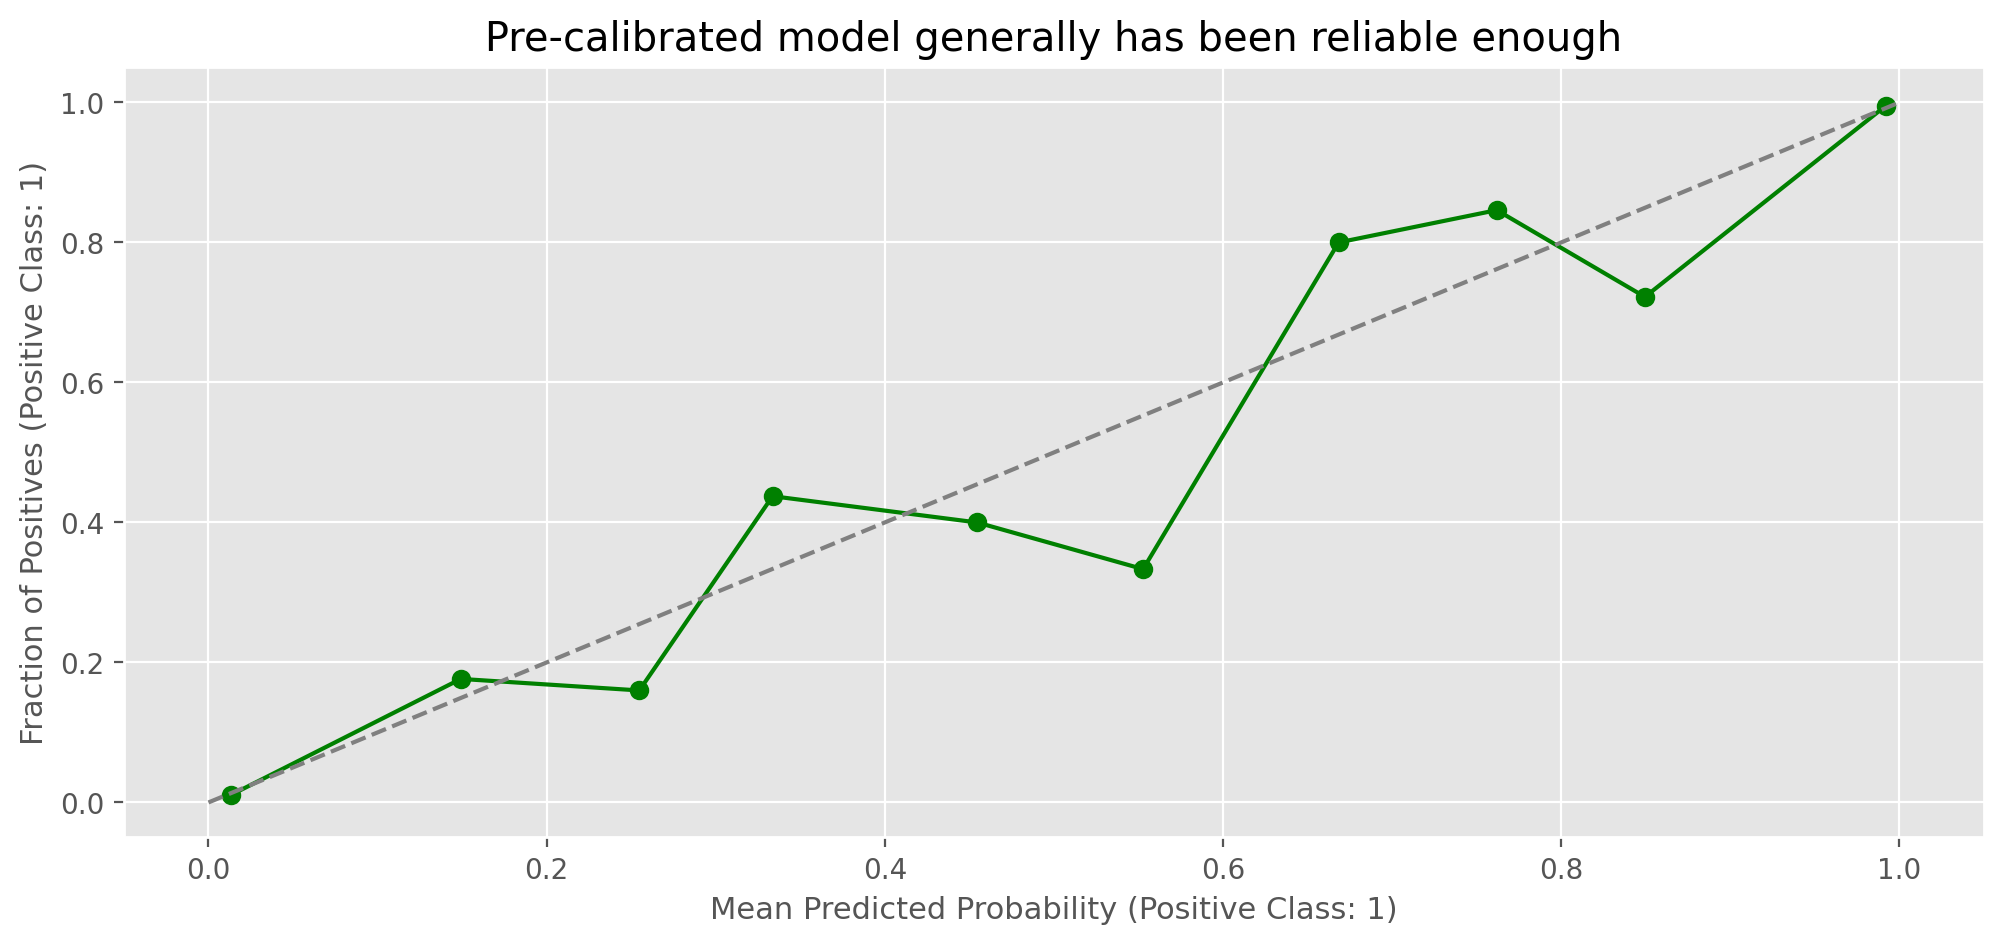

In [34]:
# predict probabilities on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# plot Reliability Curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.figure(figsize=(12, 5), dpi=200)
plt.plot(prob_pred, prob_true, marker='o', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability (Positive Class: 1)', size=11)
plt.ylabel('Fraction of Positives (Positive Class: 1)', size=11)
plt.title('Pre-calibrated model generally has been reliable enough')
plt.show()

In [35]:
# get reliability in numbers
precalibration_df = pd.DataFrame({
    'Predicted Probability': prob_pred,
    'Fraction of Positives': prob_true
})

precalibration_df['Difference'] = (precalibration_df['Predicted Probability'] - 
                                   precalibration_df['Fraction of Positives'])
print('Pre-calibration data:')
precalibration_df.round(2)

Pre-calibration data:


Predicted Probability  Fraction of Positives  Difference
0                   0.01                   0.01        0.00
1                   0.15                   0.18       -0.03
2                   0.25                   0.16        0.09
3                   0.33                   0.44       -0.10
4                   0.45                   0.40        0.05
5                   0.55                   0.33        0.22
6                   0.67                   0.80       -0.13
7                   0.76                   0.85       -0.08
8                   0.85                   0.72        0.13
9                   0.99                   1.00       -0.00

In [36]:
# compute brier score
y_true = y_test
y_prob_test = best_model.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(y_true, y_prob_test)
print(f"Brier score of pre-calibrated model: {brier_score:.4f}")

Brier score of pre-calibrated model: 0.0320


**Comment**: The points on the reliability curve are quite close to the diagonal line, which indicates that the uncalibrated model is fairly reliable. This means that the predicted probabilities are reasonably well-aligned with the actual outcomes, even before any calibration. We will check how calibration model can adjust the slight misalignment of the predicted probabilities.

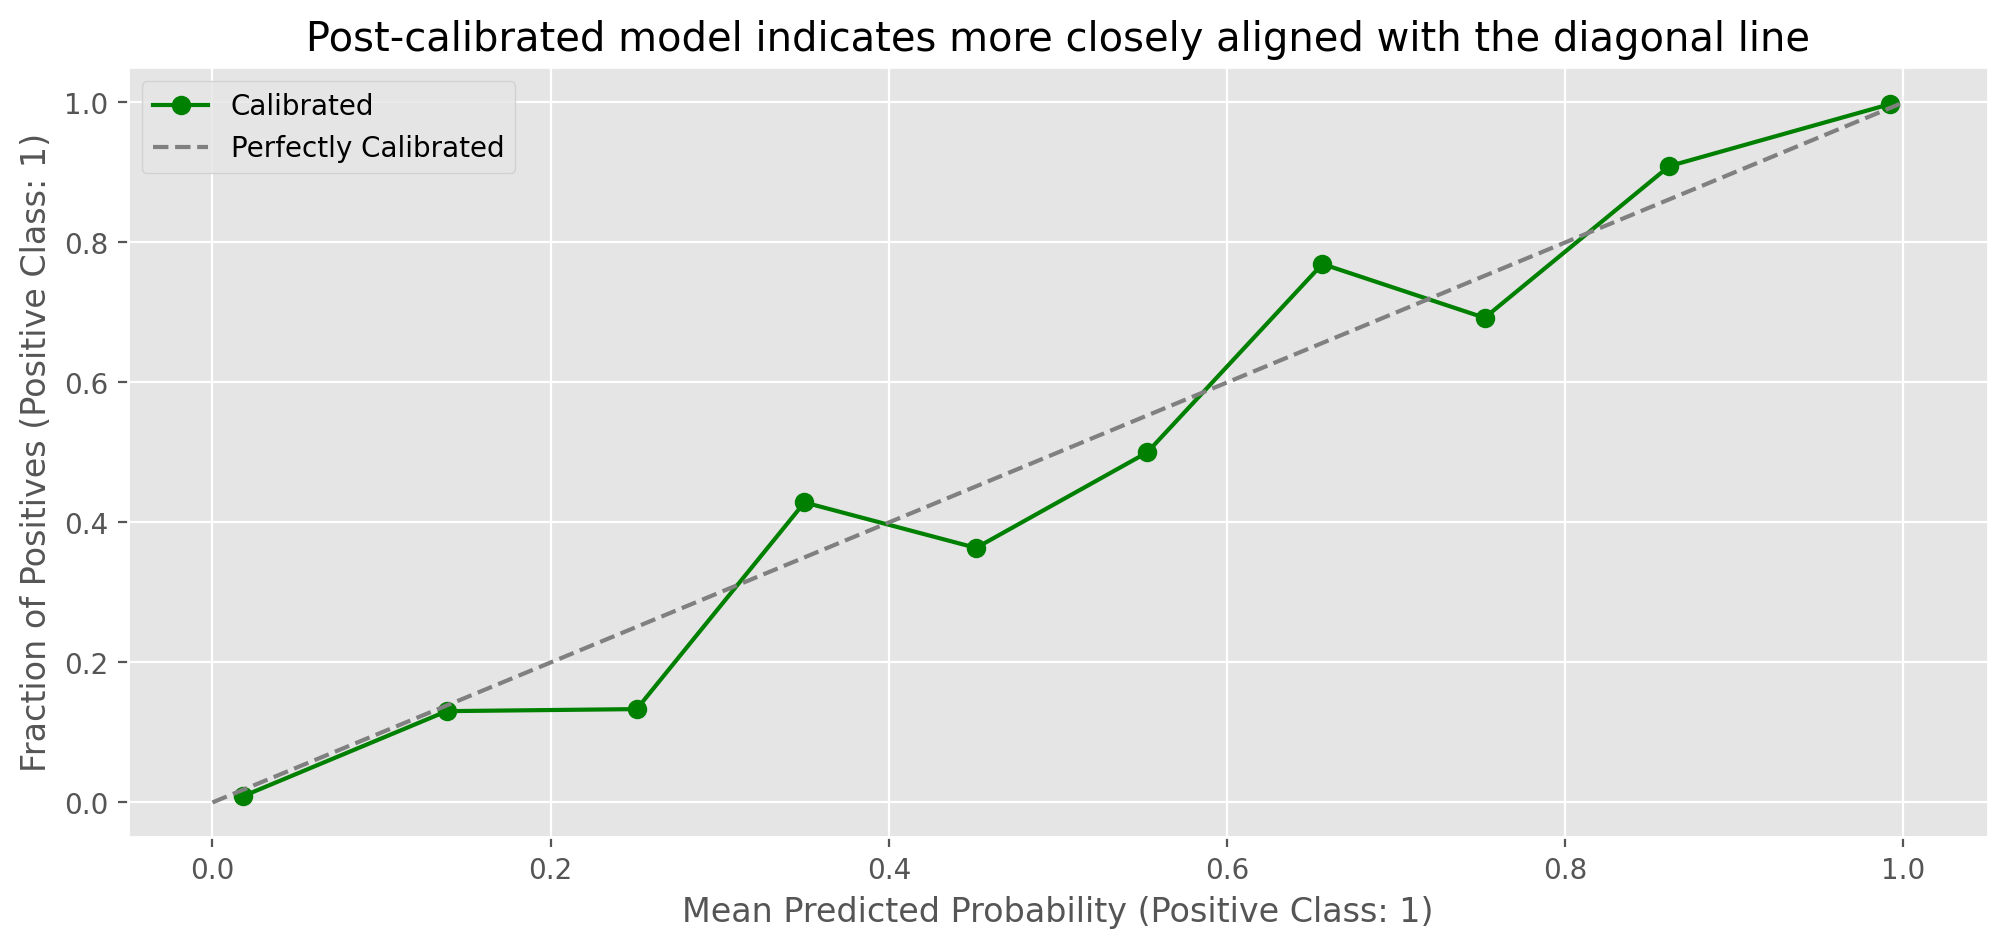

In [58]:
calibrated_clf = CalibratedClassifierCV(estimator=best_model, method='isotonic')
calibrated_clf.fit(X_train, y_train)
y_pred_proba = calibrated_clf.predict_proba(X_test)[:, 1]

# compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# plot the calibration curve
plt.figure(figsize=(12, 5), dpi=200)
plt.plot(prob_pred, prob_true, marker='o', color='green', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability (Positive Class: 1)')
plt.ylabel('Fraction of Positives (Positive Class: 1)')
plt.title('Post-calibrated model indicates more closely aligned with the diagonal line')
plt.legend(loc='best')
plt.show()

In [59]:
postcalibration_df = pd.DataFrame({
    'Predicted Probability': prob_pred,
    'Fraction of Positives': prob_true
})
print('Post-calibration data:')
postcalibration_df['Difference'] = (postcalibration_df['Predicted Probability'] - 
                                    postcalibration_df['Fraction of Positives'])
postcalibration_df.round(2)

Post-calibration data:


Predicted Probability  Fraction of Positives  Difference
0                   0.02                   0.01        0.01
1                   0.14                   0.13        0.01
2                   0.25                   0.13        0.12
3                   0.35                   0.43       -0.08
4                   0.45                   0.36        0.09
5                   0.55                   0.50        0.05
6                   0.66                   0.77       -0.11
7                   0.75                   0.69        0.06
8                   0.86                   0.91       -0.05
9                   0.99                   1.00       -0.01

In [39]:
# compute brier score
y_prob_test = calibrated_clf.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(y_true, y_prob_test)
print(f"Brier score of pre-calibrated model: {brier_score:.4f}")

Brier score of pre-calibrated model: 0.0318


<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

#### **3.1.5 Confusion Matrix: Pre and Post Calibration**

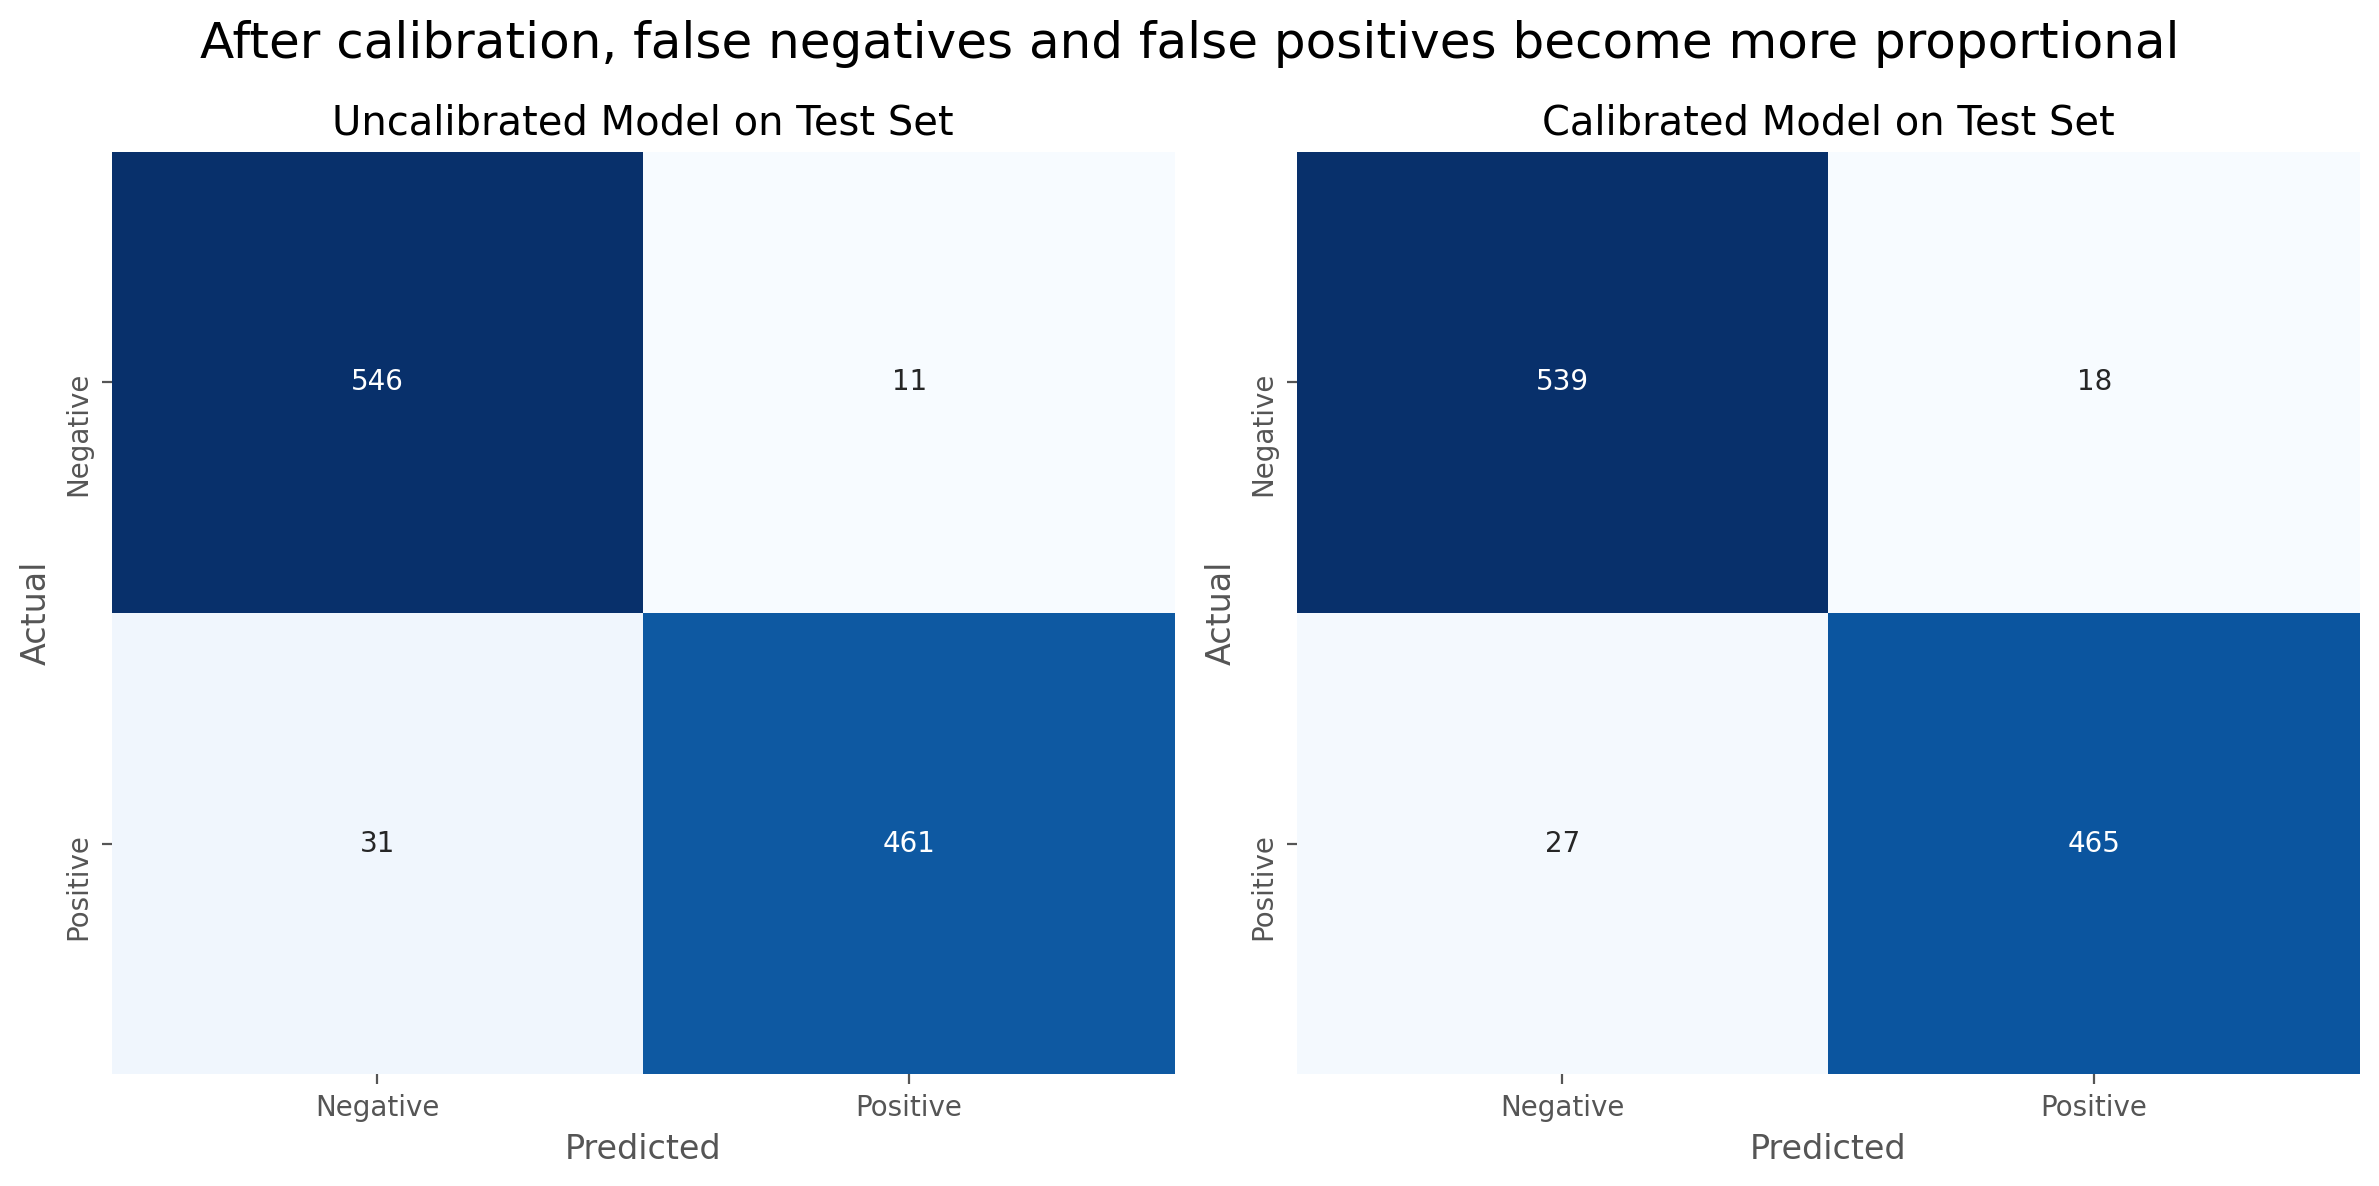

In [40]:
# Predict on the test set for both models
y_pred_test_uncal = best_model.predict(X_test)
y_pred_test_cal = calibrated_clf.predict(X_test)

# Compute confusion matrices
cm_uncal = confusion_matrix(y_test, y_pred_test_uncal)
cm_cal = confusion_matrix(y_test, y_pred_test_cal)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=200)

# Plot confusion matrix for uncalibrated model
sns.heatmap(cm_uncal, annot=True, fmt='g', ax=axs[0], cmap='Blues', cbar=False)
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_title('Uncalibrated Model on Test Set')
axs[0].set_xticklabels(['Negative', 'Positive'])
axs[0].set_yticklabels(['Negative', 'Positive'])

# Plot confusion matrix for calibrated model
sns.heatmap(cm_cal, annot=True, fmt='g', ax=axs[1], cmap='Blues', cbar=False)
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Calibrated Model on Test Set')
axs[1].set_xticklabels(['Negative', 'Positive'])
axs[1].set_yticklabels(['Negative', 'Positive'])

# Adjust layout
plt.suptitle('After calibration, false negatives and false positives become more proportional', 
             size=18)
plt.tight_layout()
plt.show()

<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

### **3.2 Best Model Explanation (XAI)**
#### **3.2.1 How Support Vector Machine Works**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

#### **3.2.2 Global Explanation: Feature Importance**

In [41]:
# get coefficients of linear SVM
coefficients = best_model.named_steps['classifier'].coef_.toarray().flatten()  # convert to dense

# get feature names from vectorizer
feature_names = vectorizer.get_feature_names_out()

# take top positive and negative coefficients
top_positive_coefficients = np.argsort(coefficients)[-10:]  # top 10 positive
top_negative_coefficients = np.argsort(coefficients)[:10]   # top 10 negative

# Prepare data for visualization
top_features_idx = np.concatenate([top_negative_coefficients, top_positive_coefficients])
top_features = feature_names[top_features_idx]
top_coefficients = coefficients[top_features_idx]
top_features_df = pd.DataFrame({'Feature': top_features, 'Coefficient': top_coefficients})

# specify colors
top_features_df['Color'] = np.where(top_features_df['Coefficient'] > 0, 'blue', 'red')

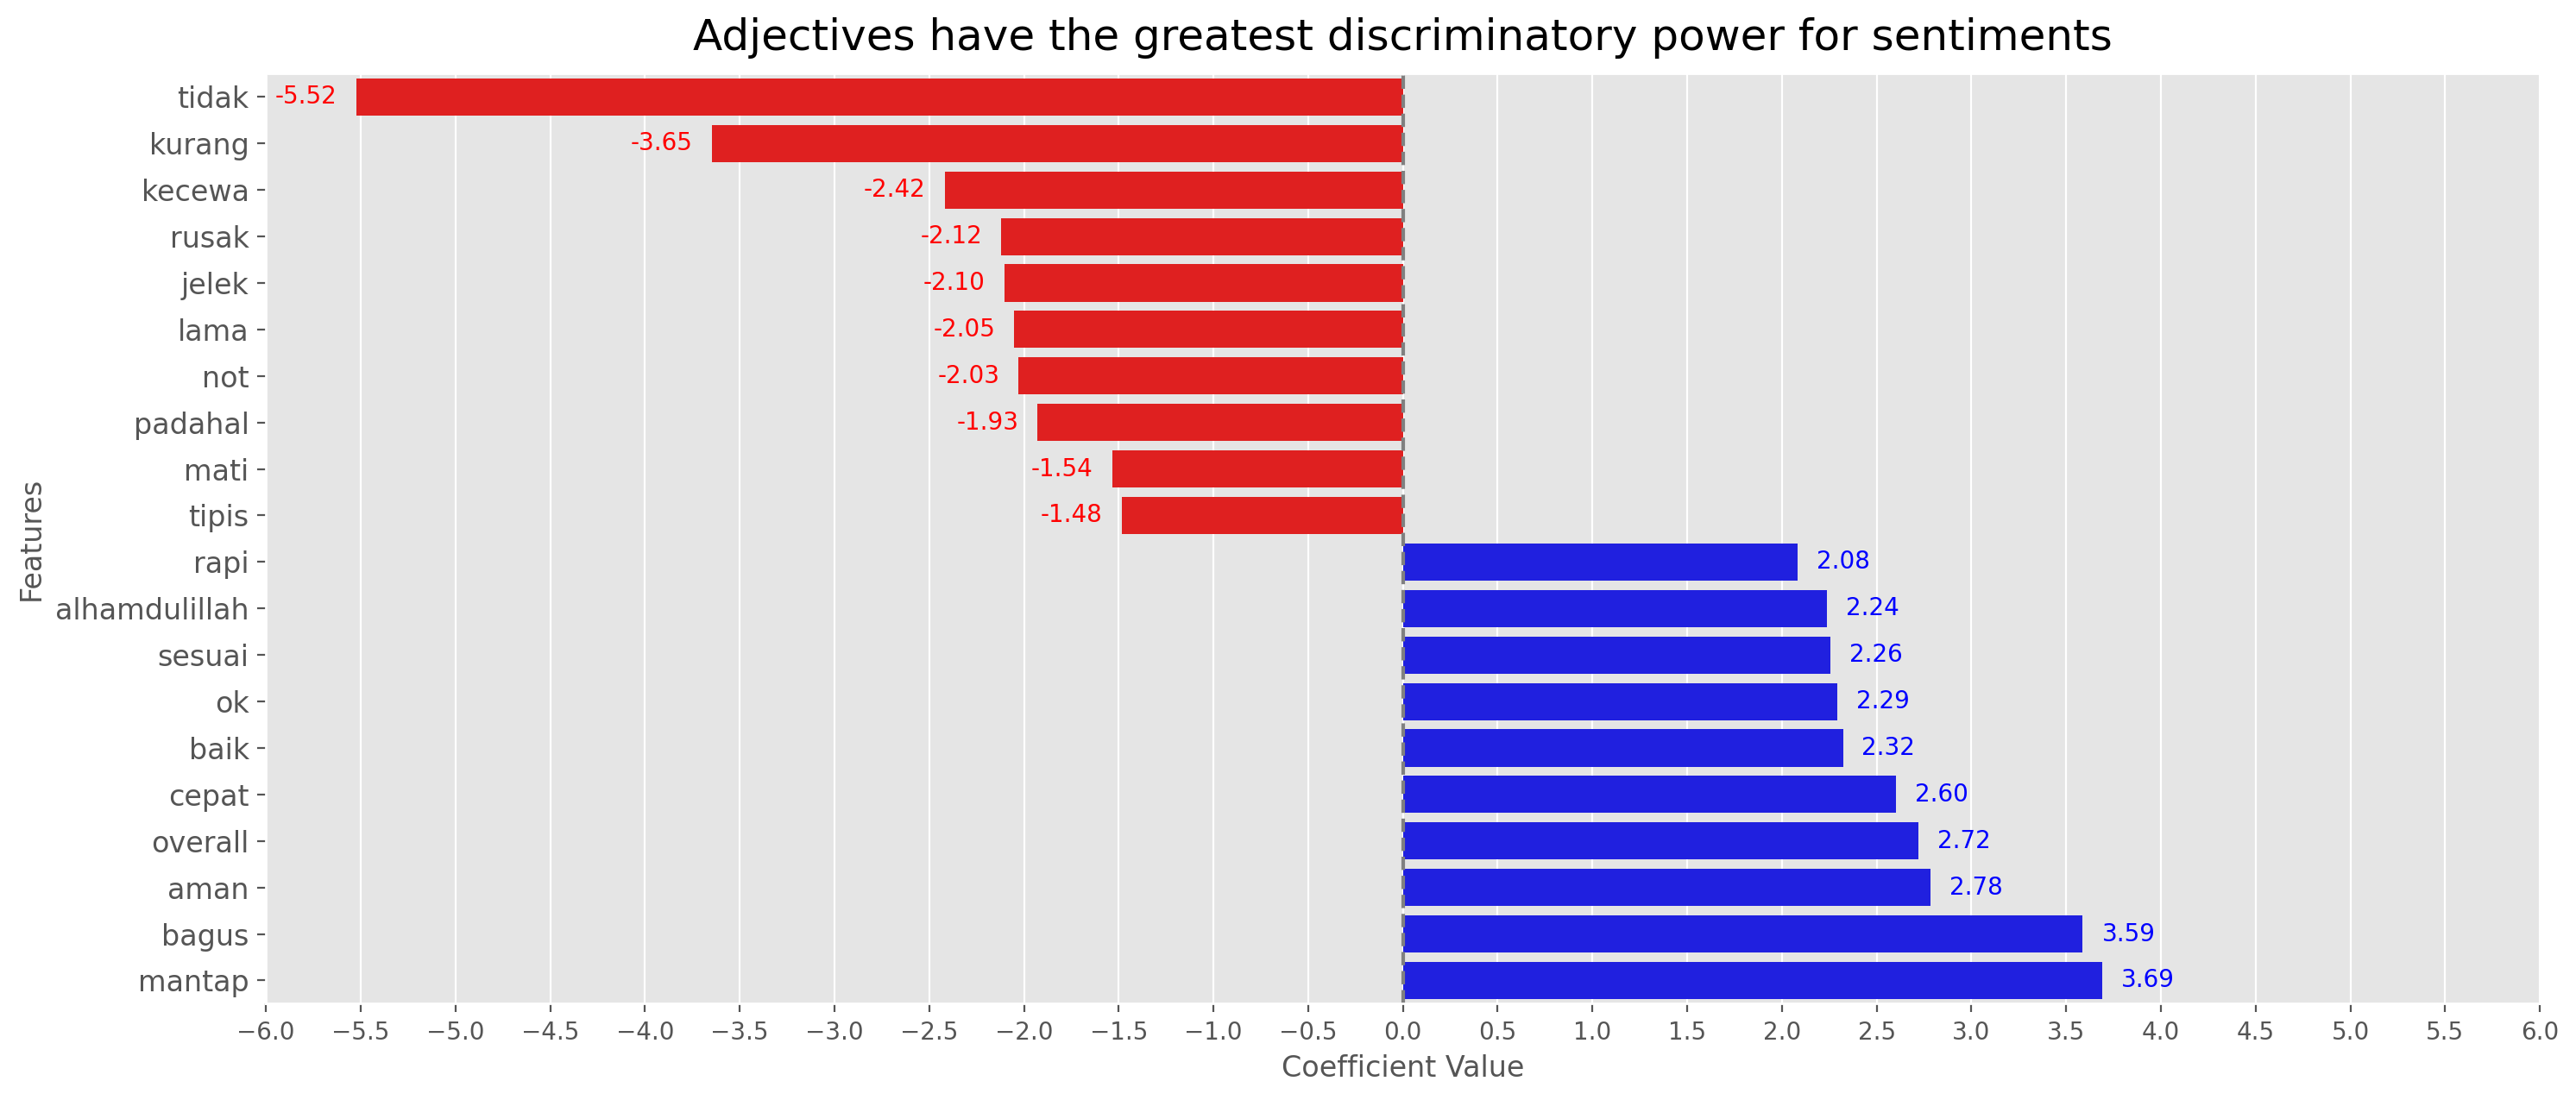

In [56]:
# create diverging bar chart
plt.figure(figsize=(17, 7), dpi=200)
sns.barplot(x='Coefficient', y='Feature', data=top_features_df, palette=top_features_df['Color'])
plt.axvline(0, color='grey', linestyle='--')  # add a vertical line at 0
plt.xticks(np.arange(-6, 6.5, 0.5))
plt.yticks(size=12)
plt.title('Adjectives have the greatest discriminatory power for sentiments',
          y=1.01, size=18)
plt.xlabel('Coefficient Value', size=12)
plt.ylabel('Features', size=12)

# add data labels
for index, row in top_features_df.iterrows():
    # adjust distance between bar and data label
    distance = 0.1
    x_pos = row['Coefficient'] + distance if row['Coefficient'] > 0 else row['Coefficient'] - distance
    plt.text(x_pos, index, f'{row["Coefficient"]:.2f}',
             color='blue' if row['Color'] == 'blue' else 'red',
             ha='left' if row['Coefficient'] > 0 else 'right',
             va='center', fontsize=10)
plt.show()

- berapa banyak kata tidak dan not di sentimen negatif? apakah ada instance yg punya sentimen positif dengan kata tidak dan not?

<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [43]:
tidak_df = df[df['CleanReview'].str.contains('tidak')]
tidakNegative_df = df[(df['CleanReview'].str.contains('tidak')) & (df['Sentiment'] == 'Negative')]
tidakPositive_df = df[(df['CleanReview'].str.contains('tidak')) & (df['Sentiment'] == 'Positive')]
print(f'Total instances containing \'tidak\': {len(tidak_df)/len(df)*100:.2f}%')
print(f'- Total negative instances containing \'tidak\': {len(tidakNegative_df)/len(df)*100:.2f}%')
print(f'- Total positive instances containing \'tidak\': {len(tidakPositive_df)/len(df)*100:.2f}%')

Total instances containing 'tidak': 34.58%
- Total negative instances containing 'tidak': 28.76%
- Total positive instances containing 'tidak': 5.82%


In [44]:
# mantap_df = df[df['CleanReview'].str.contains('mantap')]
# mantapNegative_df = df[(df['CleanReview'].str.contains('tidak')) & (df['Sentiment'] == 'Negative')]
# mantapPositive_df = df[(df['CleanReview'].str.contains('tidak')) & (df['Sentiment'] == 'Positive')]
# print(f'Total instances containing \'tidak\': {len(mantap_df)/len(df)*100:.2f}%')
# print(f'- Total negative instances containing \'tidak\': {len(mantapNegative_df)/len(df)*100:.2f}%')
# print(f'- Total positive instances containing \'tidak\': {len(mantapPositive_df)/len(df)*100:.2f}%')

In [45]:
df[(df['CleanReview'].str.contains('tidak')) & (df['Sentiment'] == 'Negative')]['CleanReview']

40      jelek yang pasti jauh dari ori mousepad jadi t...
41                                    tidak bisa di pakai
43      kecewa penjual tidak tanggung jawab komplen be...
44      pas beli nanya dulu tipe untuk macbook pro inc...
47      tidak ada tissue pembersih atau alat bantuan l...
                              ...                        
5135    pengiriman sehari awalnya beli ini karena eksp...
5136                warna tidak sesuai dg yang diinginkan
5137    barang yang dikirim tidak sesuai promosi menge...
5138    sangat mengecewakan barang dikirim tidak sesua...
5141    parah barang rusak retak di komplain malah uru...
Name: CleanReview, Length: 1508, dtype: object

<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [46]:
# display coefficient
eli5.show_weights(best_model.named_steps['classifier'], 
                  feature_names=vectorizer.get_feature_names_out())

<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

#### **3.2.3 Local Explanation: Text Explainer**

In [47]:
# Use vectorizer to transform the raw text instance into the required format
instance_raw = X_test.iloc[1]                               # Assuming X_test_raw contains raw text data
instance_vectorized = vectorizer.transform([instance_raw])  # Transform to the same format used for training

# Display the explanation
explanation = eli5.explain_prediction(best_model.named_steps['classifier'], instance_vectorized, 
                                       feature_names=vectorizer.get_feature_names_out())
eli5.show_prediction(best_model.named_steps['classifier'], instance_vectorized, 
                     feature_names=vectorizer.get_feature_names_out())

<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [48]:
# prevent resetting index on X_test
X_test_raw = X_test
X_test_raw = X_test_raw.reset_index(drop=True)  

# init LIME for text data
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])

# Use instance for explanation
exp = explainer.explain_instance(X_test_raw[1], calibrated_clf.predict_proba)

# Show explanation 
exp.show_in_notebook(text=True)

<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [49]:
# Original text
original_text = "Ikannya mati jadi saya kecewa"
counterfactual_text = "Ikannya mantap jadi saya kecewa"

# Step 1: Predict with the original text
original_prediction = (best_model.named_steps['classifier']
                       .predict_proba(vectorizer.transform([original_text]))[0])

# original_prediction_rounded = np.round(original_prediction, 4)
print(f"Original Text: {original_text}")
print(f"Prediction (Original): {np.round(original_prediction, 3)}")

# Step 2: Predict with the counterfactual text
counterfactual_prediction = (best_model.named_steps['classifier']
                             .predict_proba(vectorizer.transform([counterfactual_text]))[0])

# counterfactual_prediction_rounded = np.round(counterfactual_prediction, 4)
print(f"\nCounterfactual Text: {counterfactual_text}")
print(f"Prediction (Counterfactual): {np.round(counterfactual_prediction, 3)}")

# Step 3: Show comparison of predictions
if original_prediction[1] < counterfactual_prediction[1]:
    print("\nThe counterfactual text has a more positive sentiment.")
else:
    print("\nThe counterfactual text does not lead to a more positive sentiment.")

Original Text: Ikannya mati jadi saya kecewa
Prediction (Original): [1. 0.]

Counterfactual Text: Ikannya mantap jadi saya kecewa
Prediction (Counterfactual): [0.5 0.5]

The counterfactual text has a more positive sentiment.


In [50]:
# LIME explanation for original text
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])
exp_original = explainer.explain_instance(original_text, best_model.predict_proba)
print("LIME explanation for original instance:")
exp_original.show_in_notebook(text=True)

# LIME explanation for counterfactual text
exp_counterfactual = explainer.explain_instance(counterfactual_text, best_model.predict_proba)
print("LIME explanation for counterfactual instance:")
exp_counterfactual.show_in_notebook(text=True)

LIME explanation for original instance:


LIME explanation for counterfactual instance:


<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

#### **3.2.4 Error Analysis**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [51]:
# liat di gender prediction

#### **3.2.5 Model Saving**

In [52]:
# Save the trained model to a file
print(f'Best model: {calibrated_clf}')
joblib.dump(calibrated_clf, '../model/calib_best_model_tfidf.pkl')
print(f'Best model successfully saved!')

Best model: CalibratedClassifierCV(estimator=Pipeline(steps=[('vectorizer',
                                                  TfidfVectorizer()),
                                                 ('classifier',
                                                  SVC(C=1, kernel='linear',
                                                      probability=True))]),
                       method='isotonic')
Best model successfully saved!


<h1 style='color:orange; text-align:center; font-weight:bold'>---END---</h1>

### **5.3 Global Explanation: Feature Importance with Eli5**

```python
import eli5
from eli5.sklearn import PermutationImportance

# compute permutation importance
perm_importance = PermutationImportance(best_model.named_steps['classifier'], 
                                        random_state=42).fit(X_test_tfidf.toarray(), y_test)

# display results
eli5.show_weights(perm_importance, feature_names=vectorizer.get_feature_names_out())
```

### **5.4 Global Explanation: Permutation Importance**

```python
# convert sparse matrix to dense format
X_test_dense = X_test_tfidf.toarray() 

# perform permutation importance 
perm_importance = permutation_importance(best_model.named_steps['classifier'], 
                                         X_test_dense, y_test, n_repeats=10)

# get feature importance scores
importance_scores = perm_importance.importances_mean

# retrieve the feature names
feature_names = vectorizer.get_feature_names_out()

# create and sort df by importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# display top features
display(importance_df.head(10))

# create boxplot for permutation importance
plt.figure(figsize=(12, 6))
sns.boxplot(x='Importance', y='Feature', data=importance_df)
plt.title('Boxplot of Feature Importance from Permutation Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.axvline(0, color='grey', linestyle='--')  
plt.show()
```